v0 was retired on nov16. lifted over matrix table, then annotated, and then called de novos. used default dnv paramaters. 

v1 annotated before liftover, then called de novos, and then created lifted over coordinates. retired nov30 

v2 changed code for annotation and annotation resources. All annotations besides vep now come from either /gpfs/gibbs/pi/brueckner/hail_resources/combined_reference_data_grch37.ht or /gpfs/gibbs/pi/brueckner/hail_resources/combined_reference_data_grch38.ht

v3 uses the jointcalled vcf phil created 

# Import stuff

In [1]:
from hl_functions import *
hl.init(log='./log.log')
#hl.init(master='spark://c22n03.ruddle.hpc.yale.internal:7077')

2022-01-26 09:20:48 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.1.2
SparkUI available at http://c17n03.ruddle.hpc.yale.internal:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.81-edeb70bc789c
LOGGING: writing to ./log.log


In [52]:
import csv
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
from pcgc_hail.hail_scripts.utils import *
#from new_names import *
import gnomad
from gnomad_methods import *
from gnomad_methods.gnomad.sample_qc import *

def hl_to_txt(hl_df, name, delim='\t'):
    """Convert matrix table to pandas dataframe and output to file"""
    df = hl_df.to_pandas()
    df.to_csv(name, sep=delim)

import bokeh.io
from bokeh.io import * 
from bokeh.layouts import *
from bokeh.models import *
hl.plot.output_notebook()

Loading BokehJS ...

In [57]:
from matplotlib import pyplot as plt

In [13]:
#rebrand names
datahub_col_names = {
    'Blinded ID': 'sample_id', 
    'Gender' : 'reported_gender_str', 
    'In Trio' : 'in_trio', 
    'Is Proband' : 'is_proband', 
    'Relationship' : 'reported_relationship' 
}

# User Updates 

In [29]:
# Update with desired paths 

#####################################
# directories to read and write from 
#####################################

# Make sure these directories have a slash at the end
hl_outdir = "/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/"
#sample_info_dir = '/gpfs/gibbs/pi/brueckner/yale_phil/'


######################################################################################################

# path to vcf 
#vcf = '/gpfs/gibbs/pi/brueckner/Phil_Pipeline/yale_callset/yale_pipeline.vcf.gz'
#vcf = '/gpfs/gibbs/pi/brueckner/Phil_Pipeline/callset/phil_pipeline.vcf.gz'
#vcf = '/gpfs/gibbs/pi/brueckner/Phil_Joint_Calling_Pipeline/pilotcalls.vqsr.vcf.gz'
vcf = "/gpfs/gibbs/pi/brueckner/Phil_Joint_Calling_Pipeline/wes14.draft.calls.vcf.gz"

#########################
# paths to sample info
#########################

# path to fam file
#ped = sample_info_dir + 'yale-phil_1-00844.fam' # yale-phil.fam and impute female in for sample 1-00844 

#proband_tsv = sample_info_dir + 'proband_table.txt'
#proband_ht = sample_info_dir + 'proband_table.ht'

##################################
# main paths
##################################
# Paths for vcf, matrix tables after splitting multi-allelic sites and left normalizing, and after annotating 
# naming matrix tables after row and/or column annotations: r#c# indicates number of rounds of annotations

#Phil (new jointcalling by Phil)
hl_outdir = "/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/"
#dnv_outdir = '/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/'
vcf = "/gpfs/gibbs/pi/brueckner/Phil_Joint_Calling_Pipeline/wes14.draft.calls.vcf.gz"
unsplit_mt = hl_outdir + 'unsplit_phil.mt' 
split_mt = hl_outdir + 'split.mt' 
vep_mt = hl_outdir + 'vep.mt' 
vep_r1_mt = hl_outdir + 'vep_r1.mt' 
vep_r1c1_mt = hl_outdir + 'vep_r1c1.mt'
vep_r1c1_intervals_mt = hl_outdir + 'vep_r1c1_intervals.mt' # filtered to exome evaluations intervals 

######################################################################################################

#dnv_ht = hl_outdir + 'dnv.ht'
#dnv_default_ht = dnv_outdir + 'dnv_default.ht' 

#dnv_count_per_sample_tsv = dnv_outdir + 'dnv_count_per_sample.tsv' 
#dnv_count_per_sample_ht = dnv_outdir + 'dnv_count_per_sample.ht' 
#final_dnv_count_per_sample_ht = dnv_outdir + 'final_dnv_count_per_sample.ht'
#final_dnv_count_per_proband_ht = dnv_outdir + 'final_dnv_count_per_proband.ht'

# path to gold standard dnv tsvs
#dnv_gold_37_tsv = sample_info_dir + 'dnv_gold_37.txt'

# annotate gold standard with whether the variant is called in the dnv set 
## generated from the yale dataframe and from phil's dataframe
#gold_dnvs_ht = sample_info_dir + 'gold_standard_dnvs.ht'
#gold_dnvs_comparison_ht = sample_info_dir + 'gold_dnvs_comparison.ht'

# intervals 
# /gpfs/ycga/project/lek/shared/resources/hg38/exome_evaluation_regions.v1.interval_list

################################################################################
# paths to annotation resources for hg37
'''
vep_json = '/gpfs/gibbs/pi/brueckner/14_v0/vep85-loftee-ruddle-b37.json'
ref_data = '/gpfs/gibbs/pi/brueckner/hail_resources/combined_reference_data_grch37.ht'

cadd_ht = '/gpfs/gibbs/pi/brueckner/datasets/CADD/CADD.v1.4.GRCh37.ht'
dbnsfp_ht = '/gpfs/gibbs/pi/brueckner/datasets/dbNSFP/dbnsfp4.0a.GRCh37.ht' # 4.0 
kg_genomes = '/gpfs/gibbs/pi/brueckner/datasets/thousand_genomes/1000_Genomes_autosomes.phase_3.GRCh37.mt'
gnomad_exomes = '/gpfs/ycga/project/lek/shared/data/gnomad/gnomad.exomes.r2.1.1.sites.ht' 
gnomad_pca_ht = '/gpfs/ycga/project/lek/shared/resources/hail/gnomad.r2.1.pca_loadings.ht'

'''
################################################################################
# paths to annotation resources for hg38

vep_json = '/gpfs/gibbs/pi/brueckner/14_v0/vep85-loftee-ruddle-b38.json'
ref_data = '/gpfs/gibbs/pi/brueckner/hail_resources/combined_reference_data_grch38.ht'

cadd_ht = '/gpfs/gibbs/pi/brueckner/datasets/CADD/CADD.v1.4.GRCh38.ht'
dbnsfp_ht = '/gpfs/gibbs/pi/brueckner/datasets/dbNSFP/dbnsfp4.0a.GRCh38.ht' # 4.0 
kg_genomes = '/gpfs/gibbs/pi/brueckner/datasets/thousand_genomes/1000_Genomes_autosomes.phase_3.GRCh38.mt'


################################################################################
print('done')


done


In [27]:
ht_input= ref_data
ht = hl.read_table(ht_input)
print('Reads in the hail table: \n' + ht_input + '\n')

ht.describe()

Reads in the hail table: 
/gpfs/gibbs/pi/brueckner/hail_resources/combined_reference_data_grch38.ht

----------------------------------------
Global fields:
    'date': str 
    'datasets': set<str> 
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'g1k': struct {
        AC: int32, 
        AF: float64, 
        AN: int32, 
        POPMAX_AF: float64
    } 
    'mpc': struct {
        MPC: str
    } 
    'cadd': struct {
        PHRED: float32
    } 
    'eigen': struct {
        Eigen_phred: float64
    } 
    'dbnsfp': struct {
        SIFT_pred: str, 
        Polyphen2_HVAR_pred: str, 
        MutationTaster_pred: str, 
        FATHMM_pred: str, 
        MetaSVM_pred: str, 
        REVEL_score: str, 
        GERP_RS: str, 
        phastCons100way_vertebrate: str
    } 
    'topmed': struct {
        AC: int32, 
        AF: float64, 
        AN: int32, 
        Hom: int32, 
        Het: int32
    } 
    'primate_ai': str

In [23]:
mt_input = "/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split.mt"
mt = hl.read_matrix_table(mt_input)
print('Reads in the matrix table: \n' + mt_input + '\n')
print('count of the input dataframe: ' + str(mt.count()) + '\n')
#mt = mt.filter_rows(mt.row.filters , keep=True)
#mt = mt.filter_cols(mt.batch_number == "NPCGC", keep=True)
print(mt.count())

ht = mt.cols()
ht = ht.key_by(ht.s)
ht = ht.select(ht.sample_qc.r_ti_tv)

#ht.describe()
#ht.sample_qc.r_ti_tv.show()


#ht.export('/gpfs/gibbs/pi/brueckner/yale_phil/scratch/titv.txt')
#mt.filter.show()

Reads in the matrix table: 
/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split.mt

count of the input dataframe: (2221704, 1119)

(2221704, 1119)


AttributeError: Table instance has no field, method, or property 'sample_qc'
    Did you mean:
        Table method: 'sample'

# VCF -> Matrix Table (unsplit) -> Matrix Table (split)

In [7]:
# VCF to hail matrix table 

# /gpfs/gibbs/pi/brueckner/Phil_Joint_Calling_Pipeline/pilotcalls.vqsr.vcf.gz

#vcf = 
mt_output = split_mt 

################################################################################
print('Reads in:' + vcf)
print('Writes out:' + mt_output)

# if using genome 37
#mt = hl.import_vcf(vcf, force_bgz=True, reference_genome='GRCh37')

# if using genome 38
# for whether to use recode see https://hail.is/docs/0.2/methods/impex.html#hail.methods.import_vcf
recode = {f"{i}":f"chr{i}" for i in (list(range(1, 23)) + ['X', 'Y'])}
mt = hl.import_vcf(vcf, force_bgz=True, reference_genome='GRCh38', contig_recoding=recode)

# count before splitting 
print(str(mt.count()) + '\n')

# split multi-allelic sites  
mt = generate_split_alleles(mt)

# count after splitting 
print(str(mt.count()) + '\n')

mt.write(mt_output, overwrite = True)


Reads in:/gpfs/gibbs/pi/brueckner/Phil_Joint_Calling_Pipeline/pilotcalls.vqsr.vcf.gz
Writes out:/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/split_phil.mt


2022-01-09 16:57:03 Hail: INFO: Coerced sorted dataset==>         (44 + 9) / 53]


(2788202, 597)



2022-01-09 16:57:14 Hail: INFO: Coerced sorted dataset===>        (45 + 8) / 53]


(2913341, 597)



2022-01-09 16:57:26 Hail: INFO: Coerced sorted dataset==========> (52 + 1) / 53]
2022-01-09 16:58:34 Hail: INFO: wrote matrix table with 2913341 rows and 597 columns in 53 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/split_phil.mt


# Annotate matrix table of split alleles with VEP

In [30]:
# check inputs and outputs before running vep since %%capture prevents print() from displaying on screen
mt_input = "/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split.mt"
mt = hl.read_matrix_table(mt_input)
mt_input = split_mt
mt_output = vep_mt

print('Reads in the following matrix table: \n' + mt_input + '\n')

print('Uses the following json file for vep: \n' + vep_json + '\n')

print('Writes out to the following matrix table: \n' + mt_output + '\n')


Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split.mt

Uses the following json file for vep: 
/gpfs/gibbs/pi/brueckner/14_v0/vep85-loftee-ruddle-b38.json

Writes out to the following matrix table: 
/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/vep.mt



In [31]:
%%capture

mt_input = split_mt
mt_output = vep_mt

print('Reads in the following matrix table: \n' + mt_input + '\n')
mt = hl.read_matrix_table(mt_input)

print('Writes out to the following matrix table: \n' + mt_output + '\n')

mt_vep = hl.vep(mt, vep_json)
mt_vep.write(mt_output, overwrite = True)

KeyboardInterrupt: 

### Finish vep annotations and add gnomad_AF annotation

In [ ]:
# r1
##############################################################################
# Sort VEP transcript consequences array 
# annotate with desired VEP annotations as new row fields
# add gnomad 
# drop parent VEP struct (optional)
# write new matrix table 
##############################################################################

################################
# specify inputs and outputs 
################################
mt_input = vep_mt # specify the matrix table you wish to annotate. At minimum should already be annotated with VEP. 
mt_output = vep_r1_mt

################################
mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
#print('count of the input dataframe:' + str(mt.count()) + '\n')

ref_data_ht = hl.read_table(ref_data)
print('Reads in the following hail table for annotation: \n' + ref_data + '\n')

################################
# add annotations (from vep)
################################

# Sort VEP array annotations 
##  sort transcript consequences 
mt = mt.annotate_rows(
    sortedTranscriptConsequences=get_expr_for_vep_sorted_transcript_consequences_array(vep_root=mt.vep)
)

# Annotate rows with index zero element of array sorted transcript annotations 
# Annotate rows with additional fields from VEP parent structure before dropping
# Annotate rows with gnomad AF (Assign 0.0 to variants without a gnomAD frequency)
mt = mt.annotate_rows(
    gene_symbol=hl.if_else(mt.sortedTranscriptConsequences.size() > 0, mt.sortedTranscriptConsequences[0].gene_symbol, hl.missing(hl.tstr)), 
    major_consequence=hl.if_else(mt.sortedTranscriptConsequences.size() > 0, mt.sortedTranscriptConsequences[0].major_consequence, hl.missing(hl.tstr)), 
    hgvs=hl.if_else(mt.sortedTranscriptConsequences.size() > 0, mt.sortedTranscriptConsequences[0].hgvs, hl.missing(hl.tstr)), 
    category=hl.if_else(mt.sortedTranscriptConsequences.size() > 0, mt.sortedTranscriptConsequences[0].category, hl.missing(hl.tstr)), 
    canonical=hl.if_else(mt.sortedTranscriptConsequences.size() > 0, mt.sortedTranscriptConsequences[0].canonical, -1),
    polyphen_pred=hl.if_else(mt.sortedTranscriptConsequences.size() > 0, mt.sortedTranscriptConsequences[0].polyphen_prediction, hl.missing(hl.tstr)),
    sift_pred=hl.if_else(mt.sortedTranscriptConsequences.size() > 0, mt.sortedTranscriptConsequences[0].sift_prediction, hl.missing(hl.tstr)),
    most_severe_consequence = mt.vep.most_severe_consequence,
    variant_class = mt.vep.variant_class,
    gene_id_array = mt.vep.transcript_consequences.gene_id,
    gene_symbol_array = mt.vep.transcript_consequences.gene_symbol,
    #gnomad_af = hl.if_else(hl.is_defined(ref_data_ht[mt.row_key]), ref_data_ht[mt.row_key].gnomad_exomes.AF, 0.0)
    gnomad_af =  hl.if_else(hl.is_defined(ref_data_ht[mt.row_key]),(hl.if_else(hl.is_defined(ref_data_ht[mt.row_key].gnomad_exomes.AF),ref_data_ht[mt.row_key].gnomad_exomes.AF, 0.0)), 0.0),
    meta_svm =  hl.if_else(hl.is_defined(ref_data_ht[mt.row_key]),(hl.if_else(hl.is_defined(ref_data_ht[mt.row_key].dbnsfp.MetaSVM_pred),ref_data_ht[mt.row_key].dbnsfp.MetaSVM_pred, 'na')), 'na'),
    cadd =  hl.if_else(hl.is_defined(ref_data_ht[mt.row_key]),(hl.if_else(hl.is_defined(ref_data_ht[mt.row_key].cadd.PHRED),ref_data_ht[mt.row_key].cadd.PHRED, 0.0)), 0.0)
)


# drop parent vep structure 
mt = mt.drop(mt.vep)

################################
# write new matrix table
################################

print('Writes out to the following matrix table: \n' + mt_output + '\n')
mt.write(mt_output, overwrite = True)


### Add additional annotations

In [6]:
# Annotate with TiTv, n_snps, etc 

mt_input = vep_r1_mt
mt_output = vep_r1c1_mt

print('Reads in the following matrix table: \n' + mt_input + '\n')
mt = hl.read_matrix_table(mt_input)

mt = hl.sample_qc(mt, name='sample_qc')

print('Writes out to the following matrix table: \n' + mt_output + '\n')
mt.write(mt_output, overwrite = True)


Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1.mt

Writes out to the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1c1.mt



2022-01-09 18:43:05 Hail: INFO: wrote matrix table with 2913341 rows and 597 columns in 53 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1c1.mt


In [10]:
# Filter matrix table rows to specific intervals

mt_input = vep_r1c1_mt # (2913341, 597)
mt_output = vep_r1c1_intervals_mt # (409586, 597)

mt = hl.read_matrix_table(mt_input)
print('Reads in the matrix table: \n' + mt_input + '\n')
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

intervals = '/gpfs/ycga/project/lek/shared/resources/hg38/exome_evaluation_regions.v1.interval_list'
exome_intervals = hl.import_locus_intervals(intervals, reference_genome='GRCh38')

mt = mt.filter_rows(hl.is_defined(exome_intervals[mt.locus]), keep=True)
mt = hl.sample_qc(mt, name='sample_qc')

print('Writes the matrix table: \n' + mt_output + '\n')
mt.write(mt_output, overwrite = True)


Reads in the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1c1.mt



2022-01-09 18:54:22 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (user-supplied)
  Loading field 'f1' as type int32 (user-supplied)
  Loading field 'f2' as type int32 (user-supplied)
  Loading field 'f3' as type str (user-supplied)
  Loading field 'f4' as type str (user-supplied)


Writes the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1c1_intervals.mt



2022-01-09 18:54:24 Hail: INFO: Coerced sorted dataset              (0 + 1) / 1]
2022-01-09 18:55:27 Hail: INFO: Coerced sorted dataset              (0 + 1) / 1]
2022-01-09 18:57:11 Hail: INFO: wrote matrix table with 409586 rows and 597 columns in 53 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1c1_intervals.mt
    Total size: 1001.61 MiB
    * Rows/entries: 1001.55 MiB
    * Columns: 62.49 KiB
    * Globals: 11.00 B
    * Smallest partition: 4991 rows (12.19 MiB)
    * Largest partition:  10500 rows (25.46 MiB)


In [49]:
intervals = '/gpfs/ycga/project/lek/shared/resources/hg38/exome_evaluation_regions.v1.interval_list'
exome_intervals = hl.import_locus_intervals(intervals, reference_genome='GRCh38')
mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'sample_qc': struct {
        dp_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        gq_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        call_rate: float64, 
        n_called: int64, 
        n_not_called: int64, 
        n_filtered: int64, 
        n_hom_ref: int64, 
        n_het: int64, 
        n_hom_var: int64, 
        n_non_ref: int64, 
        n_singleton: int64, 
        n_snp: int64, 
        n_insertion: int64, 
        n_deletion: int64, 
        n_transition: int64, 
        n_transversion: int64, 
        n_star: int64, 
        r_ti_tv: float64, 
        r_het_hom_var: float64, 
        r_insertion_deletion: float64
    }
----------------------------

2022-01-25 22:15:27 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (user-supplied)
  Loading field 'f1' as type int32 (user-supplied)
  Loading field 'f2' as type int32 (user-supplied)
  Loading field 'f3' as type str (user-supplied)
  Loading field 'f4' as type str (user-supplied)


In [11]:
# get counts
mt_input = vep_r1c1_mt
mt_output = vep_r1c1_intervals_mt

################################################################################
input_mt = hl.read_matrix_table(mt_input)
output_mt = hl.read_matrix_table(mt_output)

print('count of the input dataframe:' + str(input_mt.count()) + '\n')
print('count of the output dataframe:' + str(output_mt.count()) + '\n')

count of the input dataframe:(2913341, 597)

count of the output dataframe:(409586, 597)



### Count variant classes and consequence types

In [7]:
mt_input = vep_r1c1_mt
mt = hl.read_matrix_table(mt_input)

print('Reads in the following matrix table: \n' + mt_input)
print('count of the input dataframe:' + str(mt.count()) + '\n')

# mt.describe()

# How many of each variant class? 
vep_variant_class = mt.variant_class
variant_class_dict = mt.aggregate_rows(hl.agg.counter(vep_variant_class))
print('Number of each variant class:')
pprint.pprint(variant_class_dict) 
print('\n')

# How many of each consequence type?
vep_most_severe_consequence = mt.most_severe_consequence
most_severe_term_dict = mt.aggregate_rows(hl.agg.counter(vep_most_severe_consequence))
print('Number of each consequence type:')
pprint.pprint(most_severe_term_dict)
print('\n')


Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1c1.mt
count of the input dataframe:(2913341, 597)



Number of each variant class:
frozendict({'SNV': 2598862, 'deletion': 180993, 'insertion': 131850, None: 1636})




Number of each consequence type:
frozendict({'3_prime_UTR_variant': 416536, '5_prime_UTR_variant': 156117, 'TFBS_ablation': 2, 'TF_binding_site_variant': 132, 'coding_sequence_variant': 122, 'downstream_gene_variant': 64238, 'frameshift_variant': 10507, 'incomplete_terminal_codon_variant': 25, 'inframe_deletion': 5892, 'inframe_insertion': 2607, 'intergenic_variant': 45283, 'intron_variant': 911266, 'mature_miRNA_variant': 456, 'missense_variant': 236130, 'non_coding_transcript_exon_variant': 732046, 'non_coding_transcript_variant': 2, 'protein_altering_variant': 135, 'regulatory_region_variant': 7904, 'splice_acceptor_variant': 5802, 'splice_donor_variant': 5743, 'splice_region_variant': 59070, 'start_lost': 788, 'stop_gained': 6679, 'stop_lost': 697, 'stop_retained_variant': 170, 'synonymous_variant': 144444, 'transcript_ablation': 5, 'upstream_gene_variant': 98907, None: 1636})




# Filter samples on which to call de novos 

In [100]:
#mt_input = yale_b38_intervals_DP_mt
print('Reads in the matrix table: \n' + mt_input + '\n')

#mt_output = yale_b38_filtered_mt
print('Writes the matrix table: \n' + mt_output + '\n')
#############################################################################
#mt = hl.read_matrix_table(mt_input)
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

#mt = mt.filter_cols(mt.sample_qc.n_snp == 0, keep=False)
#mt = mt.filter_cols(mt.sample_qc.r_ti_tv < 2.7, keep=False)

#############################################################################
#mt.write(mt_output, overwrite = True)

Reads in the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_intervals_DP.mt

Writes the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered.mt



2021-12-05 19:19:26 Hail: INFO: wrote matrix table with 330110 rows and 597 columns in 31 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered.mt


In [103]:
# get counts
mt_input = phil_b38_intervals_DP_mt
mt_output = phil_b38_filtered_mt 

################################################################################
input_mt = hl.read_matrix_table(mt_input)
output_mt = hl.read_matrix_table(mt_output)

print('count of the input dataframe:' + str(input_mt.count()) + '\n')
print('count of the output dataframe:' + str(output_mt.count()) + '\n')

count of the input dataframe:(409574, 592)

count of the output dataframe:(409574, 556)



# De Novo
### Call DNVs

In [ ]:
# Parameters
'''
# default paramaters 
min_gq=20, 
min_p=0.05, 
max_parent_ab=0.05, 
min_child_ab=0.2, 
min_dp_ratio=0.1, 
ignore_in_sample_allele_frequency=False

# most lenient parameters 
min_gq=0, 
min_p=0.00, 
max_parent_ab=1.00, 
min_child_ab=0.0, 
min_dp_ratio=0.0, 
ignore_in_sample_allele_frequency=True
'''

In [20]:
# Call DNVs and annotate resulting hail table with row fields from matrix table 

#if adjusting parameters from defaults rename file accordingly

#parameters = '_default-parameters'
parameters = '_lenient'
#parameters = '_min_child_ab=0.3_max_parent_ab=0.035'
#parameters = '_min_child_ab=0.35_max_parent_ab=0.035'
#parameters = '_min_child_ab=0.4_max_parent_ab=0.035'
#parameters = '_min_child_ab=0.45_max_parent_ab=0.035'

# dnv_ht = dnv_outdir + parameters + '_unfiltered' + '.ht'

dnv_ht = dnv_outdir + '_unfiltered' + parameters + '.ht'

mt_input = vep_r1c1_mt
mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
#print('count of the input dataframe:' + str(mt.count()) + '\n')

ht_output = dnv_ht
print('Writes out to the following hail table: \n' + ht_output + '\n')

ped_input = ped 
pedigree = hl.Pedigree.read(ped_input) 
print('Reads in the following pedigree: \n' + ped_input + '\n')

#dnv_results = (hl.de_novo(mt, pedigree, pop_frequency_prior=mt.gnomad_af)).key_by('locus','alleles')

# make sure the parameters you use below match the adjusted_parameters the output is named with
dnv_results = (hl.de_novo(mt, pedigree, pop_frequency_prior=mt.gnomad_af, 
                          min_gq=0, 
                          min_p=0.0, 
                          max_parent_ab=1.0, 
                          min_child_ab=0.0, 
                          min_dp_ratio=0.0, 
                          ignore_in_sample_allele_frequency=True
                         )).key_by('locus','alleles')

#print('count of the dnv_ht dataframe:' + str(dnv_results.count()) + '\n')

ht = mt.rows()

# Annotate De Novo results table with all annotations of interest
dnv_results = dnv_results.annotate(
    gene=ht[dnv_results.key].gene_symbol, 
    major_consequence=ht[dnv_results.key].major_consequence, 
    hgvs=ht[dnv_results.key].hgvs, 
    #category=ht[dnv_results.key].category, 
    canonical=ht[dnv_results.key].canonical, 
    gnomad_AF=ht[dnv_results.key].gnomad_af,
    #cadd_score = ht[dnv_results.key].scaled_cadd_score,
    #meta_svm_pred = ht[dnv_results.key].meta_svm,
    variant_class=ht[dnv_results.key].variant_class,
    filters=ht[dnv_results.key].filters
)

# annotate dnv_results with vqsr as a string for downstream filtering 
ht1 = dnv_results.select(dnv_results.filters)
ht1 = ht1.expand_types()
#ht1 = ht1.annotate(locus_37 = hl.locus(ht1.locus.contig, ht1.locus.position, reference_genome='GRCh37'))
#ht1 = ht1.key_by(locus_37=ht1.locus_37, alleles=ht1.alleles)
ht1 = ht1.annotate(locus_38 = hl.locus(ht1.locus.contig, ht1.locus.position, reference_genome='GRCh38'))
ht1 = ht1.key_by(locus_38=ht1.locus_38, alleles=ht1.alleles)

#ht1 = ht1.annotate(vqsr = hl.if_else(ht1.filters.size() > 0, ht1.filters[0], hl.missing(hl.tstr))) 
ht1 = ht1.annotate(vqsr = hl.if_else(ht1.filters.size() > 0, ht1.filters[0], 'empty_pass')) 
dnv_results = dnv_results.annotate(vqsr = ht1[dnv_results.key].vqsr)

'''
# annotate dnv_results with whether the site appears in frequent flier list from Lifton lab
# the blackslist is a list of frequent fliers from the Lifton Lab 
blacklist_sites = '/gpfs/ycga/project/brueckner/nsd35/hail_misc/frequent_fliers.ht'
blacklist_ht = hl.read_table(blacklist_sites)
print('Reads in: \n' + blacklist_sites + '\n')
dnv_results = dnv_results.key_by(locus=dnv_results.locus)
dnv_results = dnv_results.annotate(in_blacklist = hl.if_else(hl.is_defined(blacklist_ht[dnv_results.locus]), True, False),)
dnv_results = dnv_results.key_by(locus=dnv_results.locus, alleles=dnv_results.alleles)
'''

#dnv_results.describe()

dnv_results.write(ht_output, overwrite=True)


Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1c1.mt

Writes out to the following hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/_unfiltered_lenient.ht

Reads in the following pedigree: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale-phil_1-00844.fam



2022-01-10 03:25:14 Hail: WARN: Found 5 samples with missing sex information (not 1 or 2).
 Missing samples: [{'1-07081', '1-07149', '1-05787', '1-06965', '1-06757'}]
2022-01-10 03:26:27 Hail: INFO: Coerced sorted dataset==========> (52 + 1) / 53]
2022-01-10 03:29:03 Hail: INFO: wrote table with 723344 rows in 53 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/_unfiltered_lenient.ht


In [47]:
##############################################################################
# Filter DNV calls and write to TSV  
# generates counts of total variants (rows) and counts per variant class 
# filters major_consequence (_consequence)
# filter non-PASS vqsr (empty_pass)
# remove low/medium confidence, filter DP and AF, apply hl.distinct()
# filter frequent fliers 
# write 
##############################################################################

#parameters = '_min_child_ab=0.3_max_parent_ab=0.035'
#ht_input ='/gpfs/gibbs/pi/brueckner/_pcgc13/output/dnv_v3/_unfiltered_min_child_ab=0.3_max_parent_ab=0.035.ht'

#parameters = '_min_child_ab=0.35_max_parent_ab=0.035'
#ht_input = '/gpfs/gibbs/pi/brueckner/_pcgc13/output/dnv_v3/_unfiltered_min_child_ab=0.35_max_parent_ab=0.035.ht'

#parameters = '_min_child_ab=0.4_max_parent_ab=0.035'
#ht_input = '/gpfs/gibbs/pi/brueckner/_pcgc13/output/dnv_v3/_unfiltered_min_child_ab=0.4_max_parent_ab=0.035.ht'

#parameters = '_min_child_ab=0.45_max_parent_ab=0.035'
#ht_input = '/gpfs/gibbs/pi/brueckner/_pcgc13/output/dnv_v3/_unfiltered_min_child_ab=0.45_max_parent_ab=0.035.ht'

ht_input = dnv_ht #dnv_ht is the unfiltered dnv hail table 

############################################################################################################
print('parameters applied in DNV calling: \n' + parameters + '\n')
############################################################################################################
# before any filtering 
ht = hl.read_table(ht_input)
print('Reads in the hail table: \n' + ht_input + '\n')
print('Before filtering:')
print('\t' + 'Count of the dataframe:' + str(ht.count()))

# How many of each variant class? 
vep_variant_class = ht.variant_class
variant_class_dict = ht.aggregate(hl.agg.counter(vep_variant_class))
print('\t' + 'Number of each variant class:' + '\n' + '\t' + '\t' + str(variant_class_dict) + '\n')

# write unfiltered hail table as tsv 
# hl_to_txt(ht, dnv_outdir + '_unfiltered' + parameters + '.tsv')

############################################################################################################

# Variant consequence filtering
consequences = hl.set(['splice_acceptor_variant', 
                       'splice_donor_variant', 
                       'stop_gained', 
                       'stop_lost', 
                       'missense_variant', 
                       'frameshift_variant', 
                       'start_lost',
                      'inframe_insertion',
                      'inframe_deletion',
                      'splice_region_variant',
                      'synonymous_variant'])

#print('Count of the input dataframe before filtering:' + str(mt.count()) + '\n')
# major VEP consequence filtering 
ht = ht.filter(consequences.contains(ht.major_consequence), keep = True)
print('After filtering on VEP consequence:')
print('\t' + 'Count of the dataframe:' + str(ht.count()))
vep_variant_class = ht.variant_class
variant_class_dict = ht.aggregate(hl.agg.counter(vep_variant_class))
print('\t' + 'Number of each variant class:' + '\n' + '\t' + '\t' + str(variant_class_dict) + '\n')

#ht.write(dnv_outdir + '_consequence' + parameters + '.ht', overwrite = True)
# hl_to_txt(ht, dnv_outdir + '_consequence' +  parameters + '.tsv')

####################################################################################

# filter non-PASS variants
#ht = ht.filter(ht.vqsr == "empty_pass", keep=True)
print('After filtering to PASS variants:')
print('\t' + 'Count of the dataframe:' + str(ht.count()))
vep_variant_class = ht.variant_class
variant_class_dict = ht.aggregate(hl.agg.counter(vep_variant_class))
print('\t' + 'Number of each variant class:' + '\n' + '\t' + '\t' + str(variant_class_dict) + '\n')

# Remove low/medium confidence DNV calls  
ht = ht.filter(ht.confidence == "LOW", keep=False)
ht = ht.filter(ht.confidence == "MEDIUM", keep=False)
print('After filtering LOW/MEDIUM confidence calls:')
print('\t' + 'Count of the dataframe:' + str(ht.count()))
vep_variant_class = ht.variant_class
variant_class_dict = ht.aggregate(hl.agg.counter(vep_variant_class))
print('\t' + 'Number of each variant class:' + '\n' + '\t' + '\t' + str(variant_class_dict) + '\n')

# DP Filtering 
ht = ht.filter(ht.proband_entry.DP >= 10, keep=True)
ht = ht.filter(ht.father_entry.DP >= 10, keep=True)       
ht = ht.filter(ht.mother_entry.DP >= 10, keep=True)
print('After filtering on DP:')
print('\t' + 'Count of the dataframe:' + str(ht.count()))
vep_variant_class = ht.variant_class
variant_class_dict = ht.aggregate(hl.agg.counter(vep_variant_class))
print('\t' + 'Number of each variant class:' + '\n' + '\t' + '\t' + str(variant_class_dict) + '\n')

# AF filtering
ht = ht.filter(ht.gnomad_AF > 0.0004, keep=False)
print('After filtering on gnomad_AF:')
print('\t' + 'Count of the dataframe:' + str(ht.count()))
vep_variant_class = ht.variant_class
variant_class_dict = ht.aggregate(hl.agg.counter(vep_variant_class))
print('\t' + 'Number of each variant class:' + '\n' + '\t' + '\t' + str(variant_class_dict) + '\n')

# For rows with duplicate keys (i.e. locus and allele are dnv in more than one family) keep only one row
# would be better not to keep one of the recurrent rows but that is not supported by .distinct()
ht = ht.distinct()
print('After using .distinct():')
print('\t' + 'Count of the dataframe:' + str(ht.count()))
vep_variant_class = ht.variant_class
variant_class_dict = ht.aggregate(hl.agg.counter(vep_variant_class))
print('\t' + 'Number of each variant class:' + '\n' + '\t' + '\t' + str(variant_class_dict) + '\n')

'''
# filter variants in frequent flier blacklist 
ht = ht.filter((ht.in_blacklist == True), keep=False)
print('After filtering frequent fliers:')
print('\t' + 'Count of the dataframe:' + str(ht.count()))
vep_variant_class = ht.variant_class
variant_class_dict = ht.aggregate(hl.agg.counter(vep_variant_class))
print('\t' + 'Number of each variant class:' + '\n' + '\t' + '\t' + str(variant_class_dict) + '\n')
'''

####################################################################################

# after all filtering 
ht.write(dnv_outdir + '_filtered' +  parameters + '.ht', overwrite = True)
# hl_to_txt(ht, dnv_outdir + '_filtered' + parameters + '.tsv')

parameters applied in DNV calling: 
_lenient

Reads in the hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/_unfiltered_lenient.ht

Before filtering:
	Count of the dataframe:723344


	Number of each variant class:
		frozendict({'SNV': 457843, 'deletion': 143496, 'insertion': 120406, None: 1599})

After filtering on VEP consequence:


	Count of the dataframe:106830


	Number of each variant class:
		frozendict({'SNV': 84014, 'deletion': 12562, 'insertion': 10254})

After filtering to PASS variants:
	Count of the dataframe:106830


	Number of each variant class:
		frozendict({'SNV': 84014, 'deletion': 12562, 'insertion': 10254})

After filtering LOW/MEDIUM confidence calls:


	Count of the dataframe:3548


	Number of each variant class:
		frozendict({'SNV': 2131, 'deletion': 657, 'insertion': 760})

After filtering on DP:


	Count of the dataframe:2784


	Number of each variant class:
		frozendict({'SNV': 1668, 'deletion': 522, 'insertion': 594})

After filtering on gnomad_AF:


	Count of the dataframe:1588


	Number of each variant class:
		frozendict({'SNV': 1071, 'deletion': 193, 'insertion': 324})

After using .distinct():


	Count of the dataframe:1393


	Number of each variant class:
		frozendict({'SNV': 1021, 'deletion': 144, 'insertion': 228})



2022-01-10 09:46:17 Hail: INFO: wrote table with 1393 rows in 53 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/_filtered_lenient.ht


# compare to external set 

In [34]:
# Annotate hail table keyed by locus field with whether that locus is present or absent in your DNV calls
#my_yale_input = my_yale_dnv_ht
#my_yale_input = yale_dnv_default_ht
##############################################
#my_ht_yale = hl.read_table(my_yale_input)
#print('Reads in the following hail table: \n' + my_yale_input + '\n')
#print('count of this dataframe:' + str(my_ht_yale.count()) + '\n')
#my_ht_yale = my_ht_yale.key_by(locus=my_ht_yale.locus) 

#my_phil_input = '/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/_filtered_min_child_ab=0.35_max_parent_ab=0.035.ht'
my_phil_input = '/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/_filtered_lenient.ht'
#my_phil_input = phil_dnv_default_ht

ht_output = gold_dnvs_comparison_ht
print('Writes the hail table: \n' + ht_output + '\n') 
##############################################
my_ht_phil = hl.read_table(my_phil_input)
print('Reads in the following hail table: \n' + my_phil_input + '\n')
#print('count of this dataframe:' + str(my_ht_phil.count()) + '\n')
my_ht_phil = my_ht_phil.key_by(locus=my_ht_phil.locus)

gold_ht_input = gold_dnvs_ht
gold_ht = hl.read_table(gold_ht_input)
print('Reads in the following hail table: \n' + gold_ht_input + '\n')
#print('count of this dataframe:' + str(gold_ht.count()) + '\n')

ht = gold_ht.annotate(
    #variant_in_my_calls_from_yale_dataset_37 = hl.if_else(hl.is_defined(my_ht_yale[gold_ht.locus_37]), 'yes', 'no'),
    variant_in_my_calls_from_phil_dataset_38 = hl.if_else(hl.is_defined(my_ht_phil[gold_ht.locus_38]), 'yes', 'no')
)

ht.describe()
ht.write(ht_output, overwrite = True)


Writes the hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/gold_dnvs_comparison.ht

Reads in the following hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/_filtered_lenient.ht

Reads in the following hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/gold_standard_dnvs.ht

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'sample_id': str 
    'identifier': str 
    'variant': str 
    'CHROM': str 
    'POS': int32 
    'position': str 
    'REF': str 
    'ALT': str 
    'locus_37': locus<GRCh37> 
    'locus_liftover_38': locus<GRCh38> 
    'locus_38': locus<GRCh38> 
    'variant_in_my_calls_from_phil_dataset_38': str 
----------------------------------------
Key: ['locus_38', 'locus_37']
----------------------------------------


2022-01-10 04:17:06 Hail: INFO: Coerced sorted dataset
2022-01-10 04:17:06 Hail: INFO: wrote table with 231 rows in 1 partition to /gpfs/gibbs/pi/brueckner/yale_phil/gold_dnvs_comparison.ht


In [35]:
ht_input = gold_dnvs_comparison_ht
ht = hl.read_table(ht_input)
print('Reads in the following hail table: \n' + ht_input)
print('count of this dataframe:' + str(ht.count()) + '\n')

#ht = ht.filter((ht.variant_in_my_calls_from_yale_dataset_37 == 'no') |(ht.variant_in_my_calls_from_phil_dataset_38 == 'no') ,
#               keep=True)

ht = ht.filter((ht.variant_in_my_calls_from_phil_dataset_38 == 'no') ,
               keep=True)


#ht = ht.filter(ht.variant_in_my_calls == 'yes', keep=False)
print('count of variants not in the gold standard dataframe:' + str(ht.count()) + '\n')

#ht.describe()
ht.show(28)

#hl_to_txt(ht, "/gpfs/gibbs/pi/brueckner/yale_phil/scratch/dnv_comparison.txt")

Reads in the following hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/gold_dnvs_comparison.ht
count of this dataframe:231

count of variants not in the gold standard dataframe:10



,,,,,,,,,,,
sample_id,identifier,variant,CHROM,POS,position,REF,ALT,locus_37,locus_liftover_38,locus_38,variant_in_my_calls_from_phil_dataset_38
str,str,str,str,int32,str,str,str,locus<GRCh37>,locus<GRCh38>,locus<GRCh38>,str
"""1-04134""","""1-04134:1:206141465:AG:A""","""1:206141465:AG:A""","""1""",206141465,"""1:206141465""","""AG""","""A""",1:206141465,chr1:206199865,chr1:206199865,"""no"""
"""1-04934""","""1-04934:7:7274103:A:C""","""7:7274103:A:C""","""7""",7274103,"""7:7274103""","""A""","""C""",7:7274103,chr7:7234472,chr7:7234472,"""no"""
"""1-04863""","""1-04863:7:83590862:T:C""","""7:83590862:T:C""","""7""",83590862,"""7:83590862""","""T""","""C""",7:83590862,chr7:83961546,chr7:83961546,"""no"""
"""1-02790""","""1-02790:11:5688930:G:A""","""11:5688930:G:A""","""11""",5688930,"""11:5688930""","""G""","""A""",11:5688930,chr11:5667700,chr11:5667700,"""no"""
"""1-04863""","""1-04863:13:28844905:T:C""","""13:28844905:T:C""","""13""",28844905,"""13:28844905""","""T""","""C""",13:28844905,chr13:28270768,chr13:28270768,"""no"""
"""1-05698""","""1-05698:15:34064173:T:C""","""15:34064173:T:C""","""15""",34064173,"""15:34064173""","""T""","""C""",15:34064173,chr15:33771972,chr15:33771972,"""no"""
"""1-04863""","""1-04863:15:64449007:C:T""","""15:64449007:C:T""","""15""",64449007,"""15:64449007""","""C""","""T""",15:64449007,chr15:64156808,chr15:64156808,"""no"""
"""1-05787""","""1-05787:16:30080933:TGAG:T""","""16:30080933:TGAG:T""","""16""",30080933,"""16:30080933""","""TGAG""","""T""",16:30080933,chr16:30069612,chr16:30069612,"""no"""


# DNV per family 

In [48]:
#dnv_outdir = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/dnv_output/'
#dnv_outdir = '/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/dnv_output/'

#ht_input = dnv_ht

ht_input = '/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/_filtered_lenient.ht'
#ht_input = dnv_yale
#ht_input = dnv_phil

ht = hl.read_table(ht_input)
print('Reads in the following hail table: \n' + ht_input + '\n')
print('count of this dataframe:' + str(ht.count()) + '\n')

##########################################################################################################
# filter to dnvs of interest
'''
# Remove low confidence DNV calls  
ht = ht.filter(ht.confidence == "LOW", keep=False)
print('count of the dataframe after filtering LOW confidence calls:' + str(ht.count()) + '\n')

# DP Filtering 
ht = ht.filter(ht.proband_entry.DP >= 10, keep=True)
ht = ht.filter(ht.father_entry.DP >= 10, keep=True)       
ht = ht.filter(ht.mother_entry.DP >= 10, keep=True)   
print('count of the dataframe after also filtering on DP:' + str(ht.count()) + '\n')

# AF filtering
ht = ht.filter(ht.gnomad_AF > 0.0004, keep=False)
print('count of the dataframe after also filtering on gnomad_AF:' + str(ht.count()) + '\n')

# Retain only SNV calls 
#ht = ht.filter(ht.variant_class == "SNV", keep=True)
#print('count of the dataframe after keeping only SNVs:' + str(ht.count()) + '\n')

# Retain only calls in coding regions 

consequences = hl.set(['splice_acceptor_variant', 
                       'splice_donor_variant', 
                       'stop_gained', 
                       'stop_lost', 
                       'missense_variant', 
                       'frameshift_variant', 
                       'start_lost'])

#print('Count of the input dataframe before filtering:' + str(mt.count()) + '\n')
# major VEP consequence filtering 
ht = ht.filter(consequences.contains(ht.major_consequence), keep = True)
print('Count of the dataframe after also filtering by VEP consequence' + str(ht.count()) + '\n')
'''
##########################################################################################################
#user changes these 
tsv_output = dnv_count_per_sample_tsv
print('Writes out the following tsv: \n' + tsv_output + '\n')

# get dnv count per sample
agg_id = ht.aggregate(hl.agg.counter(ht.id))
my_dict = agg_id

# convert dictionary to pandas dataframe 
df = pd.DataFrame(list(my_dict.items()),columns = ['sample_id','dnv_count']) 

# pandas dataframe to tsv
df.to_csv(tsv_output, sep='\t', header=True, index=False)

df

Reads in the following hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/_filtered_lenient.ht

count of this dataframe:1393

Writes out the following tsv: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/dnv_count_per_sample.tsv



,sample_id,dnv_count
0,1-00008,1
1,1-00042,1
2,1-00082,2
3,1-00226,10
4,1-00249,6
...,...,...
185,1-11800,7
186,1-12248,2
187,1-12717,4
188,1-13653,6


In [49]:
# formatted tsv to hail table 

tsv_input = dnv_count_per_sample_tsv
print('Reads in the following tsv as a hail table: \n' + tsv_input + '\n')

ht_output = dnv_count_per_sample_ht
print('Writes the hail table: \n' + ht_output + '\n')

#ht = hl.import_table(tsv_input, impute=True).key_by('sample_id')
ht = hl.import_table(tsv_input, impute=True).key_by('sample_id')

#ht.describe()
ht.write(ht_output, overwrite = True)

Reads in the following tsv as a hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/dnv_count_per_sample.tsv

Writes the hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/dnv_count_per_sample.ht



2022-01-10 09:47:00 Hail: INFO: Reading table to impute column types
2022-01-10 09:47:00 Hail: INFO: Finished type imputation
  Loading field 'sample_id' as type str (imputed)
  Loading field 'dnv_count' as type int32 (imputed)
2022-01-10 09:47:00 Hail: INFO: Coerced sorted dataset
2022-01-10 09:47:00 Hail: INFO: wrote table with 190 rows in 1 partition to /gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/dnv_count_per_sample.ht


In [50]:
# get final count of dnv per sample 

mt_input = vep_r1_mt
mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
print('count of the input dataframe: ' + str(mt.count()) + '\n')

ht_input = dnv_count_per_sample_ht
ht_1 = hl.read_table(ht_input)
print('Reads in the following hail table: \n' + ht_input + '\n')
#print('count of this dataframe:' + str(ht_1.count()) + '\n')

ht_output = final_dnv_count_per_sample_ht
print('Writes the hail table: \n' + ht_output + '\n')

ht = mt.cols()
ht = ht.key_by(ht.s)
ht = ht.distinct()
ht = ht.annotate(dnv_count = ht_1[ht.s].dnv_count)
ht = ht.annotate(dnv_count = hl.coalesce(ht.dnv_count, 0))

#ht.describe()
#print(ht.count())

ht.write(ht_output, overwrite = True)

ht.show()

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1.mt

count of the input dataframe: (2913341, 597)

Reads in the following hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/dnv_count_per_sample.ht

Writes the hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/final_dnv_count_per_sample.ht



2022-01-10 09:47:01 Hail: INFO: Coerced sorted dataset
2022-01-10 09:47:01 Hail: INFO: wrote table with 597 rows in 16 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/final_dnv_count_per_sample.ht
2022-01-10 09:47:01 Hail: INFO: Coerced sorted dataset


,
s,dnv_count
str,int32
"""1-00008""",1
"""1-00008-01""",0
"""1-00008-02""",0
"""1-00042""",1
"""1-00042-01""",0
"""1-00042-02""",0
"""1-00082""",2
"""1-00082-01""",0


In [51]:
# get dnv count per proband by removing non-probands (part 1)
#input list of probands as tsv and convert to ht 
# (only need to do once since you'll have the hail table forever after writing)
'''
tsv_input = proband_tsv
print('Reads in the following tsv as a hail table: \n' + tsv_input + '\n')

ht_output = proband_ht
print('Writes the hail table: \n' + ht_output + '\n')

#ht = hl.import_table(tsv_input, impute=True).key_by('sample_id')
ht = hl.import_table(tsv_input, impute=True).key_by('sample_id')
ht.describe()

ht.write(ht_output, overwrite = True)
'''

"\ntsv_input = proband_tsv\nprint('Reads in the following tsv as a hail table: \n' + tsv_input + '\n')\n\nht_output = proband_ht\nprint('Writes the hail table: \n' + ht_output + '\n')\n\n#ht = hl.import_table(tsv_input, impute=True).key_by('sample_id')\nht = hl.import_table(tsv_input, impute=True).key_by('sample_id')\nht.describe()\n\nht.write(ht_output, overwrite = True)\n"

In [52]:
# get dnv count per proband by removing non-probands (part 2)
# annotate with probands and filter 
ht_input = final_dnv_count_per_sample_ht
ht = hl.read_table(ht_input)
print('Reads in the following hail table: \n' + ht_input + '\n')
#print('count of this dataframe:' + str(ht.count()) + '\n')

ht_output = final_dnv_count_per_proband_ht
print('Writes the hail table: \n' + ht_output + '\n')

ht_1 = hl.read_table(proband_ht)
#print('count of this dataframe:' + str(ht_1.count()) + '\n')

ht = ht.annotate(is_proband = ht_1[ht.s].is_proband)
ht = ht.filter(ht.is_proband == 'yes', keep=True)
print(ht.count())

ht.write(ht_output, overwrite = True)

Reads in the following hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/final_dnv_count_per_sample.ht

Writes the hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/final_dnv_count_per_proband.ht

199


2022-01-10 09:47:05 Hail: INFO: wrote table with 199 rows in 16 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/final_dnv_count_per_proband.ht


### Plotting DNV per family

In [54]:
# dnv per family 

ht_input = final_dnv_count_per_proband_ht
print('Reads in the following hail table: \n' + ht_input + '\n')
ht = hl.read_table(ht_input)

ht.show()

dnv_count_plot = hl.plot.histogram(ht.dnv_count, 
                                 range =(0,7), 
                                 bins = 15, 
                                 title ='Distribution of filtered DNVs per proband (ACC Jointcalling)', 
                                 legend='')


fig = dnv_count_plot
fig.xaxis.axis_label = 'DNV Count'
fig.yaxis.axis_label = 'Number of families'

fig.y_range.start = 0
fig.y_range.end = 75
fig.x_range.start = 0
fig.x_range.end = 8

fig.title.align = "center"
fig.title.text_color = "black"
fig.title.text_font_size = "20px"

fig.background_fill_color = "white"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None

fig.xaxis.axis_label_text_font_size = "19px"
fig.xaxis.axis_label_text_color = "black"
fig.xaxis.axis_label_text_font_style = "normal"

fig.yaxis.axis_label_text_font_size = "19px"
fig.yaxis.axis_label_text_color = "black"
fig.yaxis.axis_label_text_font_style = "normal"

fig.outline_line_width = 0
fig.legend.border_line_width = 0
fig.legend.label_width= 0
fig.legend.label_height= 0
# fig.legend.location = "top_left"
fig.legend.visible = True

# cutoff = Span(location=80,dimension='height', line_color='red',line_dash='dashed', line_width=3)
# fig.add_layout(cutoff)


#citation_1 = Label(x=78, y=100.05,
#                 text=' Cutoff ', render_mode='css', text_color = 'red',
#                 border_line_color='white', border_line_alpha=0,
#                 background_fill_color='white', background_fill_alpha=1)

#fig.add_layout(citation_1)



hl.plot.show(fig)

Reads in the following hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/dnv_output/final_dnv_count_per_proband.ht



,,
s,dnv_count,is_proband
str,int32,str
"""1-00008""",1,"""yes"""
"""1-00042""",1,"""yes"""
"""1-00082""",2,"""yes"""
"""1-00226""",10,"""yes"""
"""1-00249""",6,"""yes"""
"""1-00262""",6,"""yes"""
"""1-00390""",11,"""yes"""
"""1-00448""",8,"""yes"""


# Annotate with TiTv and Plot

In [20]:
# Annotate with TiTv, n_snps, etc 

mt_input = vep_r1_mt
mt_output = vep_r1c1_mt

print('Reads in the following matrix table: \n' + mt_input + '\n')
mt = hl.read_matrix_table(mt_input)

mt = hl.sample_qc(mt, name='sample_qc')

print('Writes out to the following matrix table: \n' + mt_output + '\n')
mt.write(mt_output, overwrite = True)

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/vep_r1.mt

Writes out to the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/vep_r1c1.mt



2021-12-02 14:28:44 Hail: INFO: wrote matrix table with 2910132 rows and 597 columns in 53 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/vep_r1c1.mt


In [42]:
# export tsv of r_ti_tv 
mt_input = vep_r1c1_mt # input must have been hl.sample_qc() already 

print('Reads in the following matrix table: \n' + mt_input + '\n')
mt = hl.read_matrix_table(mt_input)
#mt.describe()

ht = mt.cols()
ht = ht.key_by(ht.s)
ht = ht.select(ht.sample_qc.r_ti_tv)

#ht.describe()
#ht.sample_qc.r_ti_tv.show()


ht.export('/gpfs/gibbs/pi/brueckner/yale_phil/scratch/titv.txt')

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/vep_r1c1.mt



2021-12-02 17:52:50 Hail: INFO: Coerced sorted dataset
2021-12-02 17:52:53 Hail: INFO: merging 16 files totalling 12.2K...15 + 1) / 16]
2021-12-02 17:52:53 Hail: INFO: while writing:
    /gpfs/gibbs/pi/brueckner/yale_phil/scratch/titv.txt
  merge time: 57.655ms


In [53]:
#mt_input = phil_b38_intervals_samples_mt
#mt_input = yale_b38_intervals_mt

#mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
print(mt.count())

var_plot = hl.plot.histogram(mt.sample_qc.r_ti_tv, 
                                 range =(2.1,3.1), 
                                 bins = 100, 
                                 title ='Distribution of TiTv (WES14)', 
                                 legend='')

fig = var_plot
fig.xaxis.axis_label = 'Transition/Transversion Ratio'
fig.yaxis.axis_label = 'Number of samples'

fig.y_range.start = 0
fig.y_range.end = 70
#fig.x_range.start = 2.1
#fig.x_range.end = 2.5

fig.title.align = "center"
fig.title.text_color = "black"
fig.title.text_font_size = "20px"

fig.background_fill_color = "white"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None

fig.xaxis.axis_label_text_font_size = "17px"
fig.xaxis.axis_label_text_color = "black"
fig.xaxis.axis_label_text_font_style = "normal"

fig.yaxis.axis_label_text_font_size = "17px"
fig.yaxis.axis_label_text_color = "black"
fig.yaxis.axis_label_text_font_style = "normal"

fig.outline_line_width = 0
fig.outline_line_color = "white"

fig.legend.border_line_width = 0
fig.legend.label_width= 0
fig.legend.label_height= 0
#fig.legend.location = "top_left"
fig.legend.visible = False

# cutoff_mf = Span(location=0.5,dimension='height', line_color='black',line_dash='dashed', line_width=3)
#fig.add_layout(cutoff_mf)

'''
citation_1 = Label(x=.65, y=120,
                 text='Males', render_mode='css',
                 border_line_color='white', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=0)

fig.add_layout(citation_1)

'''

hl.plot.show(fig)

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split_intervals.mt

(641599, 1119)


# n_snps

In [55]:
#mt_input = phil_b38_intervals_samples_mt
#mt_input = "/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split.mt"
#mt = hl.read_matrix_table(mt_input)
#mt = hl.sample_qc(mt, name='sample_qc')

print('Reads in the following matrix table: \n' + mt_input + '\n')
print(mt.count())

var_plot = hl.plot.histogram(mt.sample_qc.n_snp, 
                                 range =(25000,40000), 
                                 bins = 100, 
                                 title ='Distribution of n_snp (WES14)', 
                                 legend='')

fig = var_plot
fig.xaxis.axis_label = 'n_snp'
fig.yaxis.axis_label = 'Number of samples'

fig.y_range.start = 0
fig.y_range.end = 150
fig.x_range.start = 25000
fig.x_range.end = 40000

fig.title.align = "center"
fig.title.text_color = "black"
fig.title.text_font_size = "20px"

fig.background_fill_color = "white"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None

fig.xaxis.axis_label_text_font_size = "17px"
fig.xaxis.axis_label_text_color = "black"
fig.xaxis.axis_label_text_font_style = "normal"

fig.yaxis.axis_label_text_font_size = "17px"
fig.yaxis.axis_label_text_color = "black"
fig.yaxis.axis_label_text_font_style = "normal"

fig.outline_line_width = 0
fig.outline_line_color = "white"

fig.legend.border_line_width = 0
fig.legend.label_width= 0
fig.legend.label_height= 0
#fig.legend.location = "top_left"
fig.legend.visible = False

# cutoff_mf = Span(location=0.5,dimension='height', line_color='black',line_dash='dashed', line_width=3)
#fig.add_layout(cutoff_mf)

'''
citation_1 = Label(x=.65, y=120,
                 text='Males', render_mode='css',
                 border_line_color='white', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=0)

fig.add_layout(citation_1)

'''

hl.plot.show(fig)

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split_intervals.mt

(641599, 1119)


# n_snp_2

/gpfs/ycga/project/lek/kn396/conda_envs/hail_test3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


Text(0.5, 0, 'Number of SNPs')

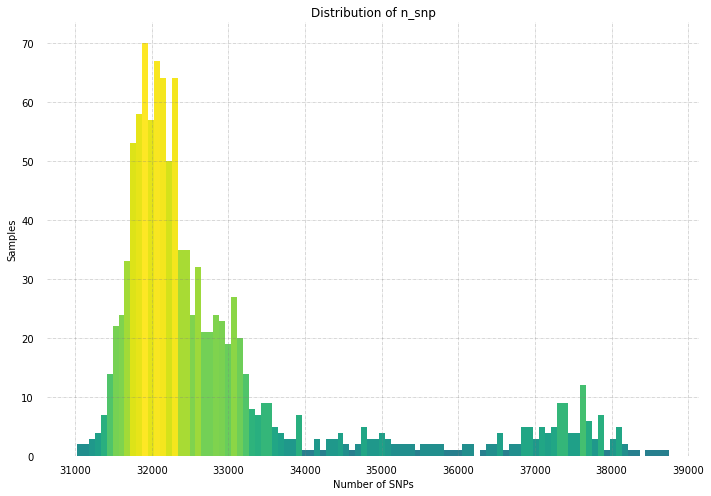

In [86]:

#mt_input = phil_b38_intervals_samples_mt
#mt_input = "/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split.mt"
#mt = hl.read_matrix_table(mt_input)
#mt = hl.sample_qc(mt, name='sample_qc')

import csv 
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

#ht = mt.cols()
#ht = ht.key_by(ht.s)
#ht = ht.select(ht.sample_qc.n_snp)
#hl_to_txt(ht, "plot.tsv")

values = []
with open("plot.tsv") as file:
    tsv_file = list(csv.reader(file, delimiter="\t"))
    for line in tsv_file[1:]:
        values.append(int(line[2]))
        
        
# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)
 
# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
axs.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

# Creating histogram
N, bins, patches = axs.hist(values, bins =100)
 
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
plt.title("Distribution of n_snp")
plt.ylabel("Samples")
plt.xlabel("Number of SNPs")


# n_snp_3

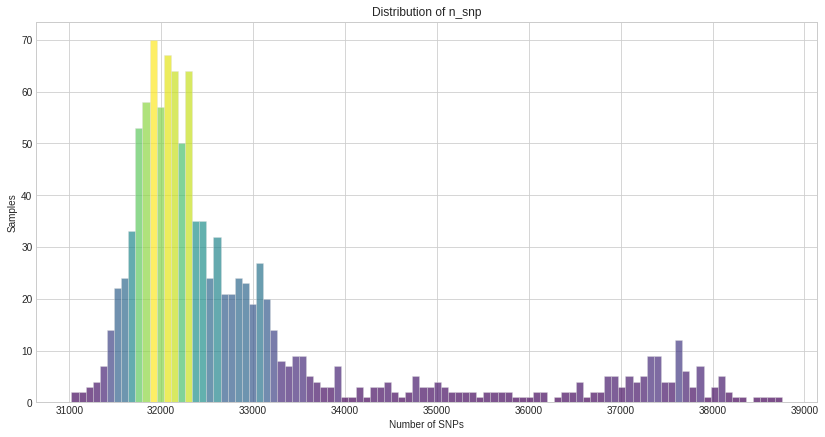

In [98]:
values = []
with open("plot.tsv") as file:
    tsv_file = list(csv.reader(file, delimiter="\t"))
    for line in tsv_file[1:]:
        values.append(int(line[2]))
    

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid

n, bins, patches = plt.hist(values, bins=100, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# Add annotation
plt.title("Distribution of n_snp")
plt.ylabel("Samples")
plt.xlabel("Number of SNPs")
plt.show()

# n_snps_4

ModuleNotFoundError: No module named 'seaborn'

# Remove samples with n_snps = 0 

In [48]:
#show samples that have n_snps = 0 

mt_input = phil_b38_intervals_mt
print('Reads in the following matrix table: \n' + mt_input + '\n')

mt = hl.read_matrix_table(mt_input)
mt = mt.filter_cols(mt.sample_qc.n_snp == 0, keep = True)
mt.count()
mt.s.show()
#type(mt.sample_qc.n_snp)


#mt.describe()

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_filtered_intervals.mt



""
s
str
"""1-02790-01"""
"""1-04863-02"""
"""1-04934"""
"""1-04947-01"""
"""1-05698-01"""


In [8]:
# remove samples with n_snps = 0
# re-annotate with hl.sample_qc

mt_input = yale_b38_intervals_mt
print('Reads in the matrix table: \n' + mt_input + '\n')

mt_output = yale_b38_intervals_samples_mt
print('Writes the matrix table: \n' + mt_output + '\n')
#############################################################################

mt = hl.read_matrix_table(mt_input)
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

mt = mt.filter_cols(mt.sample_qc.n_snp == 0, keep = False)
mt = hl.sample_qc(mt, name='sample_qc')

mt.write(mt_output, overwrite = True)

Reads in the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals.mt

Writes the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals_samples.mt



2021-12-05 12:10:25 Hail: INFO: wrote matrix table with 330110 rows and 597 columns in 31 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals_samples.mt


In [18]:
mt_input = phil_b38_intervals_samples_mt
#mt_input = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/vep_.mt'
print('Reads in the following matrix table: \n' + mt_input + '\n')
mt = hl.read_matrix_table(mt_input)
print('count of the input dataframe: ' + str(mt.count()) + '\n')
mt.describe()

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_filtered_intervals_samples.mt

count of the input dataframe: (409574, 592)

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'sample_qc': struct {
        dp_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        gq_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        call_rate: float64, 
        n_called: int64, 
        n_not_called: int64, 
        n_filtered: int64, 
        n_hom_ref: int64, 
        n_het: int64, 
        n_hom_var: int64, 
        n_non_ref: int64, 
        n_singleton: int64, 
        n_snp: int64, 
        n_insertion: int64, 
        n_deletion: int64, 
        n_transition: int64, 
        n_transversion: in

# Plot insertions/deletions

In [57]:
#mt_input = phil_b38_intervals_samples_mt
mt_input = yale_b38_intervals_mt

mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
print(mt.count())

var_plot = hl.plot.histogram(mt.sample_qc.r_insertion_deletion, 
                                 #range =(28000,42000), 
                                 bins = 100, 
                                 title ='Distribution of insertions/deletions ratio (Yale)', 
                                 legend='')

fig = var_plot
fig.xaxis.axis_label = 'r_insertions/deletions'
fig.yaxis.axis_label = 'Number of samples'

fig.y_range.start = 0
fig.y_range.end = 25
fig.x_range.start = .6
fig.x_range.end = 1.2

fig.title.align = "center"
fig.title.text_color = "black"
fig.title.text_font_size = "20px"

fig.background_fill_color = "white"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None

fig.xaxis.axis_label_text_font_size = "17px"
fig.xaxis.axis_label_text_color = "black"
fig.xaxis.axis_label_text_font_style = "normal"

fig.yaxis.axis_label_text_font_size = "17px"
fig.yaxis.axis_label_text_color = "black"
fig.yaxis.axis_label_text_font_style = "normal"

fig.outline_line_width = 0
fig.outline_line_color = "white"

fig.legend.border_line_width = 0
fig.legend.label_width= 0
fig.legend.label_height= 0
#fig.legend.location = "top_left"
fig.legend.visible = False

# cutoff_mf = Span(location=0.5,dimension='height', line_color='black',line_dash='dashed', line_width=3)
#fig.add_layout(cutoff_mf)

'''
citation_1 = Label(x=.65, y=120,
                 text='Males', render_mode='css',
                 border_line_color='white', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=0)

fig.add_layout(citation_1)

'''

hl.plot.show(fig)

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals.mt

(330110, 597)


# Filter matrix table rows to specific intervals 

In [25]:
# Filter matrix table rows to specific intervals

mt_input = yale_pre_intervals_mt # (1097716, 597)
#mt_input = phil_pre_intervals_mt # (2910132, 597)

mt_output = yale_b38_intervals_mt # (330110, 597)
#mt_output = phil_b38_intervals_mt # (409574, 597)
print('Writes the matrix table: \n' + mt_output + '\n')

mt = hl.read_matrix_table(mt_input)
print('Reads in the matrix table: \n' + mt_input + '\n')
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

intervals = '/gpfs/ycga/project/lek/shared/resources/hg38/exome_evaluation_regions.v1.interval_list'
exome_intervals = hl.import_locus_intervals(intervals, reference_genome='GRCh38')

mt = mt.filter_rows(hl.is_defined(exome_intervals[mt.locus]), keep=True)
mt = hl.sample_qc(mt, name='sample_qc')

mt.write(mt_output, overwrite = True)

Reads in the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/vep_r1c1.mt

Writes the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals.mt



2021-12-03 19:54:30 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (user-supplied)
  Loading field 'f1' as type int32 (user-supplied)
  Loading field 'f2' as type int32 (user-supplied)
  Loading field 'f3' as type str (user-supplied)
  Loading field 'f4' as type str (user-supplied)
2021-12-03 19:54:32 Hail: INFO: Coerced sorted dataset
2021-12-03 19:54:43 Hail: INFO: Coerced sorted dataset
2021-12-03 19:54:58 Hail: INFO: wrote matrix table with 330110 rows and 597 columns in 31 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals.mt
    Total size: 1.03 GiB
    * Rows/entries: 1.03 GiB
    * Columns: 62.24 KiB
    * Globals: 11.00 B
    * Smallest partition: 7638 rows (24.30 MiB)
    * Largest partition:  13465 rows (42.89 MiB)


In [27]:
# get counts
#mt_input = phil_pre_intervals_mt
#mt_output = phil_b38_intervals_mt

mt_input = yale_pre_intervals_mt
mt_output = yale_b38_intervals_mt

################################################################################
input_mt = hl.read_matrix_table(mt_input)
output_mt = hl.read_matrix_table(mt_output)

print('count of the input dataframe:' + str(input_mt.count()) + '\n')
print('count of the output dataframe:' + str(output_mt.count()) + '\n')

count of the input dataframe:(1097716, 597)

count of the output dataframe:(330110, 597)



# Annotate with batch number

In [36]:
# annotate with batch and capture info and sequencer info

mt_input = phil_b38_intervals_samples_mt
print('Reads in the matrix table: \n' + mt_input + '\n')

mt_output = phil_b38_intervals_samples_annotated_mt
print('Writes the matrix table: \n' + mt_output + '\n')

tsv_input = '/gpfs/gibbs/pi/brueckner/yale_phil/sample_batches.txt'
print('Reads in the following tsv as a hail table: \n' + tsv_input + '\n')

#############################################################################

mt = hl.read_matrix_table(mt_input)
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

ht = hl.import_table(tsv_input, impute=True).key_by('sample_id')
#ht.describe()

mt = mt.annotate_cols(
    capture_method = ht[mt.s].capture_method,
    sequencer = ht[mt.s].sequencer,
    batch_number = ht[mt.s].batch_number
)

mt.write(mt_output, overwrite = True)

Reads in the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_filtered_intervals_samples.mt

Writes the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_filtered_intervals_samples_annotated.mt

Reads in the following tsv as a hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/sample_batches.txt



2021-12-05 13:29:26 Hail: INFO: Reading table to impute column types
2021-12-05 13:29:26 Hail: INFO: Finished type imputation
  Loading field 'sample_id' as type str (imputed)
  Loading field 'capture_method' as type str (imputed)
  Loading field 'sequencer' as type str (imputed)
  Loading field 'batch_number' as type str (imputed)
2021-12-05 13:30:19 Hail: INFO: wrote matrix table with 409574 rows and 592 columns in 53 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_filtered_intervals_samples_annotated.mt


In [122]:
# Filter to batch number and plot n_snps 

#mt_input = phil_b38_intervals_samples_annotated_mt
mt_input = yale_b38_intervals_samples_annotated_mt

mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
print(mt.count())

#mt = mt.filter_cols(mt.capture_method == "V2", keep=True)
#mt = mt.filter_cols(mt.capture_method == "MedExome", keep=True)
print(mt.count())

var_plot = hl.plot.histogram(mt.sample_qc.n_snp, 
                                 range =(28000,42000), 
                                 bins = 100, 
                                 title ='Distribution of n_snp with V2 capture (Yale)', 
                                 legend='')

fig = var_plot
fig.xaxis.axis_label = 'n_snp'
fig.yaxis.axis_label = 'Number of samples'

fig.y_range.start = 0
fig.y_range.end = 20
#fig.x_range.start = 2.1
#fig.x_range.end = 2.5

fig.title.align = "center"
fig.title.text_color = "black"
fig.title.text_font_size = "20px"

fig.background_fill_color = "white"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None

fig.xaxis.axis_label_text_font_size = "17px"
fig.xaxis.axis_label_text_color = "black"
fig.xaxis.axis_label_text_font_style = "normal"

fig.yaxis.axis_label_text_font_size = "17px"
fig.yaxis.axis_label_text_color = "black"
fig.yaxis.axis_label_text_font_style = "normal"

fig.outline_line_width = 0
fig.outline_line_color = "white"

fig.legend.border_line_width = 0
fig.legend.label_width= 0
fig.legend.label_height= 0
#fig.legend.location = "top_left"
fig.legend.visible = False

# cutoff_mf = Span(location=0.5,dimension='height', line_color='black',line_dash='dashed', line_width=3)
#fig.add_layout(cutoff_mf)

'''
citation_1 = Label(x=.65, y=120,
                 text='Males', render_mode='css',
                 border_line_color='white', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=0)

fig.add_layout(citation_1)

'''

hl.plot.show(fig)

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals_samples_annotated.mt

(330110, 597)
(330110, 119)


In [ ]:
mt_input = vep_r1_mt
#mt_input = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/vep_.mt'
print('Reads in the following matrix table: \n' + mt_input + '\n')
mt = hl.read_matrix_table(mt_input)
#mt.describe()

# TiTv vs n_snps 

In [14]:
mt_input = phil_b38_intervals_DP_mt

mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')

mt.capture_method.show()

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_intervals_DP.mt



,
s,capture_method
str,str
"""1-00008""","""MedExome"""
"""1-00008-01""","""#N/A"""
"""1-00008-02""","""#N/A"""
"""1-00042""","""V2"""
"""1-00042-01""","""#N/A"""
"""1-00042-02""","""#N/A"""
"""1-00082""","""V2"""
"""1-00082-01""","""#N/A"""


In [50]:
#hail.plot.scatter(x, y, 
#label=None, title=None, xlabel=None, ylabel=None, size=4, legend=True, 
#hover_fields=None, colors=None, width=800, height=800, collect_all=False, n_divisions=500, missing_label='NA')
###########
###########################################################################################################

###########################################################################################################
###########################################################################################################

#mt_input = phil_b38_intervals_samples_annotated_mt
#mt_input = yale_b38_intervals_samples_annotated_mt

#mt_input = yale_b38_intervals_DP_mt
#mt_input = phil_b38_intervals_DP_mt

#mt_input = '/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_intervals_DP.mt'
#mt_input = '/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_intervals_DP.mt'



#mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
print(mt.count())

#mt = mt.filter_cols(mt.sample_qc.r_ti_tv < 2.7, keep=True)
var_plot = hl.plot.scatter(mt.sample_qc.n_snp, mt.sample_qc.r_ti_tv,
                           #colors=color_mapper,
                           title ='TiTv versus n_snps (Phil)')

#bokeh.models.mappers.ColorMapper or Mapping[str, bokeh.models.mappers.ColorMapper]

fig = var_plot
fig.xaxis.axis_label = 'Number of SNPs'
fig.yaxis.axis_label = 'TiTv ratio'

fig.y_range.start = 2.5
fig.y_range.end = 3.2
fig.x_range.start = 25000
fig.x_range.end = 42000

fig.title.align = "center"
fig.title.text_color = "black"
fig.title.text_font_size = "20px"

fig.background_fill_color = "white"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None

fig.xaxis.axis_label_text_font_size = "17px"
fig.xaxis.axis_label_text_color = "black"
fig.xaxis.axis_label_text_font_style = "normal"

fig.yaxis.axis_label_text_font_size = "17px"
fig.yaxis.axis_label_text_color = "black"
fig.yaxis.axis_label_text_font_style = "normal"

fig.outline_line_width = 0
fig.outline_line_color = "white"

'''fig.legend.border_line_width = 0
fig.legend.label_width= 0
fig.legend.label_height= 0
#fig.legend.location = "top_left"
#fig.legend.visible = False'''

hl.plot.show(fig)

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split_intervals.mt

(641599, 1119)


In [48]:
#hail.plot.scatter(x, y, 
#label=None, title=None, xlabel=None, ylabel=None, size=4, legend=True, 
#hover_fields=None, colors=None, width=800, height=800, collect_all=False, n_divisions=500, missing_label='NA')
###########
###########################################################################################################

###########################################################################################################
###########################################################################################################

#mt_input = phil_b38_intervals_samples_annotated_mt
#mt_input = yale_b38_intervals_samples_annotated_mt

#mt_input = yale_b38_intervals_DP_mt
#mt_input = phil_b38_intervals_DP_mt

#mt_input = '/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_intervals_DP.mt'
#mt_input = '/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_intervals_DP.mt'



#mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
print(mt.count())

#mt = mt.filter_cols(mt.sample_qc.r_ti_tv < 2.7, keep=True)
var_plot = hl.plot.scatter(mt.sample_qc.n_snp, mt.sample_qc.r_het_hom_var,
                           #colors=color_mapper,
                           title ='Het/Hom versus n_snps (WES14)')

#bokeh.models.mappers.ColorMapper or Mapping[str, bokeh.models.mappers.ColorMapper]

fig = var_plot
fig.xaxis.axis_label = 'Number of SNPs'
fig.yaxis.axis_label = 'Het/Hom ratio'

fig.y_range.start = 1.0
fig.y_range.end = 2.7
fig.x_range.start = 25000
fig.x_range.end = 42000

fig.title.align = "center"
fig.title.text_color = "black"
fig.title.text_font_size = "20px"

fig.background_fill_color = "white"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None

fig.xaxis.axis_label_text_font_size = "17px"
fig.xaxis.axis_label_text_color = "black"
fig.xaxis.axis_label_text_font_style = "normal"

fig.yaxis.axis_label_text_font_size = "17px"
fig.yaxis.axis_label_text_color = "black"
fig.yaxis.axis_label_text_font_style = "normal"

fig.outline_line_width = 0
fig.outline_line_color = "white"

'''fig.legend.border_line_width = 0
fig.legend.label_width= 0
fig.legend.label_height= 0
#fig.legend.location = "top_left"
#fig.legend.visible = False'''

hl.plot.show(fig)

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/ken_rotation/output/wes14/split_intervals.mt

(641599, 1119)


In [90]:
# Filter to batch number and plot n_snps 

mt_input = phil_b38_intervals_samples_annotated_mt
#mt_input = yale_b38_intervals_samples_annotated_mt

mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
#print(mt.count())

mt = mt.filter_cols(mt.sample_qc.r_ti_tv < 2.7, keep=True)
#mt.describe()

ht = mt.cols()
ht = ht.key_by(ht.s)
ht = ht.select(ht.sample_qc.r_ti_tv)

ht.export('/gpfs/gibbs/pi/brueckner/yale_phil/scratch/phil_titv_under2.7.txt')

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_filtered_intervals_samples_annotated.mt



2021-12-05 18:23:05 Hail: INFO: Coerced sorted dataset
2021-12-05 18:23:05 Hail: INFO: merging 16 files totalling 1.0K...
2021-12-05 18:23:05 Hail: INFO: while writing:
    /gpfs/gibbs/pi/brueckner/yale_phil/scratch/phil_titv_under2.7.txt
  merge time: 10.416ms


In [118]:
# Filter to batch number and plot n_snps 
mt_input = yale_b38_intervals_mt
#mt_input = phil_b38_intervals_samples_annotated_mt
#mt_input = yale_b38_intervals_samples_annotated_mt

mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
#print(mt.count())

tsv_input = '/gpfs/gibbs/pi/brueckner/yale_phil/sample_batches.txt'
print('Reads in the following tsv as a hail table: \n' + tsv_input + '\n')

#############################################################################

mt = hl.read_matrix_table(mt_input)
print('count of the input dataframe: ' + str(mt.count()) + '\n')

ht = hl.import_table(tsv_input, impute=True).key_by('sample_id')
#ht.describe()

mt = mt.annotate_cols(
    capture_method = ht[mt.s].capture_method,
    sequencer = ht[mt.s].sequencer,
    batch_number = ht[mt.s].batch_number
)

#mt = mt.filter_cols(mt.sample_qc.n_snp == 0, keep = True)
#mt = mt.filter_cols(mt.sample_qc.r_ti_tv < 2.7, keep=True)
mt = mt.filter_cols(mt.batch_number == "NPCGC", keep=True)
print(mt.count())
#mt.batch_number.show(50)
#mt.describe()

ht = mt.cols()
ht = ht.key_by(ht.s)
ht = ht.select(ht.batch_number)
#ht = ht.select(ht.sample_qc.r_ti_tv)

#ht.describe()
#ht.sample_qc.r_ti_tv.show()


#ht.export('/gpfs/gibbs/pi/brueckner/yale_phil/scratch/NPCGC_samples.txt')


Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals.mt

Reads in the following tsv as a hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/sample_batches.txt

count of the input dataframe: (330110, 597)



2021-12-05 21:21:11 Hail: INFO: Reading table to impute column types
2021-12-05 21:21:12 Hail: INFO: Finished type imputation
  Loading field 'sample_id' as type str (imputed)
  Loading field 'capture_method' as type str (imputed)
  Loading field 'sequencer' as type str (imputed)
  Loading field 'batch_number' as type str (imputed)


(330110, 57)


2021-12-05 21:21:12 Hail: INFO: Coerced sorted dataset
2021-12-05 21:21:12 Hail: INFO: merging 16 files totalling 927...
2021-12-05 21:21:12 Hail: INFO: while writing:
    /gpfs/gibbs/pi/brueckner/yale_phil/scratch/NPCGC_samples.txt
  merge time: 7.943ms


# Filter entires by DP

In [72]:
#mt_input = phil_b38_intervals_samples_annotated_mt
mt_input = yale_b38_intervals_samples_annotated_mt
print('Reads in the matrix table: \n' + mt_input + '\n')

#mt_output = phil_b38_intervals_DP_mt
mt_output = yale_b38_intervals_DP_mt
print('Writes the matrix table: \n' + mt_output + '\n')

#############################################################################

mt = hl.read_matrix_table(mt_input)
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

mt = mt.filter_entries(mt.DP > 20 , keep=True)
mt = hl.sample_qc(mt, name='sample_qc')

mt.write(mt_output, overwrite = True)

Reads in the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals_samples_annotated.mt

Writes the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_intervals_DP.mt



2021-12-05 14:37:38 Hail: INFO: wrote matrix table with 330110 rows and 597 columns in 31 partitions to /gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_intervals_DP.mt


In [73]:
# get counts
#mt_input = phil_b38_intervals_samples_annotated_mt
mt_input = yale_b38_intervals_samples_annotated_mt
print('Reads in the matrix table: \n' + mt_input + '\n')

#mt_output = phil_b38_intervals_DP_mt
mt_output = yale_b38_intervals_DP_mt
print('Writes the matrix table: \n' + mt_output + '\n')
################################################################################
input_mt = hl.read_matrix_table(mt_input)
output_mt = hl.read_matrix_table(mt_output)

print('count of the input dataframe:' + str(input_mt.count()) + '\n')
print('count of the output dataframe:' + str(output_mt.count()) + '\n')

Reads in the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_filtered_intervals_samples_annotated.mt

Writes the matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/v2/b38/yale_b38_intervals_DP.mt

count of the input dataframe:(330110, 597)

count of the output dataframe:(330110, 597)



## Import gold standard set of variants in GRCh37 
## Liftover to GRCh38 and add liftover coordinates as annotation
## Key by GRCh37 locus and GRCh38 locus

In [7]:
# import gold-standard tsv as ht 
tsv_input = dnv_gold_37_tsv
print('Reads in the following tsv as a hail table: \n' + tsv_input + '\n')

ht_output = gold_dnvs_ht
#ht_output = dnv_gold_37_ht
print('Writes the hail table: \n' + ht_output + '\n')

rg37 = hl.get_reference('GRCh37')  
rg38 = hl.get_reference('GRCh38')  
rg37.add_liftover('/gpfs/gibbs/pi/brueckner/hail_resources/grch37_to_grch38.over.chain.gz', rg38)  

# import gold-standard tsv as ht 
ht = hl.import_table(tsv_input, impute=True).key_by('sample_id')

# convert locus string to locus struct/type 
ht =  ht.annotate(locus_37 = hl.parse_locus(ht.position, reference_genome='GRCh37'))

# liftover locus 37 to locus 38
ht = ht.annotate(locus_liftover_38=hl.liftover(ht.locus_37, 'GRCh38'))  

#key by locus 37 and 38 
#ht = ht.filter(hl.is_defined(ht.locus_liftover_38))  # commented out 
ht = ht.key_by(locus_38=ht.locus_liftover_38, locus_37=ht.locus_37)  

ht.describe()

ht.write(ht_output, overwrite = True)

Reads in the following tsv as a hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/dnv_gold_37.txt

Writes the hail table: 
/gpfs/gibbs/pi/brueckner/yale_phil/gold_standard_dnvs.ht



2021-11-16 18:59:25 Hail: INFO: Reading table to impute column types
2021-11-16 18:59:28 Hail: INFO: Finished type imputation
  Loading field 'sample_id' as type str (imputed)
  Loading field 'identifier' as type str (imputed)
  Loading field 'variant' as type str (imputed)
  Loading field 'CHROM' as type str (imputed)
  Loading field 'POS' as type int32 (imputed)
  Loading field 'position' as type str (imputed)
  Loading field 'REF' as type str (imputed)
  Loading field 'ALT' as type str (imputed)


----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'sample_id': str 
    'identifier': str 
    'variant': str 
    'CHROM': str 
    'POS': int32 
    'position': str 
    'REF': str 
    'ALT': str 
    'locus_37': locus<GRCh37> 
    'locus_liftover_38': locus<GRCh38> 
    'locus_38': locus<GRCh38> 
----------------------------------------
Key: ['locus_38', 'locus_37']
----------------------------------------


2021-11-16 18:59:29 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-16 18:59:30 Hail: INFO: wrote table with 231 rows in 1 partition to /gpfs/gibbs/pi/brueckner/yale_phil/gold_standard_dnvs.ht


# Liftover and rekey matrix table from GRCh37 to GRCh38

In [7]:
# Liftover of matrix table from GRCh37 to GRCh38 (condensed from v0, untested, v0 works if this doesn't)
mt_input = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/split_yale_37.mt'
mt_output = '/gpfs/gibbs/pi/brueckner/yale_phil/scratch/split_yale_liftover.mt'

rg37 = hl.get_reference('GRCh37')  
rg38 = hl.get_reference('GRCh38')  
rg37.add_liftover('/gpfs/gibbs/pi/brueckner/hail_resources/grch37_to_grch38.over.chain.gz', rg38)  

mt = hl.read_matrix_table(mt_input)
print('Reads in: \n' + mt_input + '\n')

mt = mt.annotate_rows(new_locus=hl.liftover(mt.locus, 'GRCh38'))  
mt = mt.filter_rows(hl.is_defined(mt.new_locus))  
#mt = mt.key_rows_by(locus=mt.new_locus)
mt = mt.key_rows_by(locus=mt.new_locus, alleles=mt.alleles)  

print('Writes out: \n' + mt_output + '\n')
mt.write(mt_output, overwrite = True)

FatalError: HailException: Chain file already exists for source reference 'GRCh37' and destination reference 'GRCh38'.

Java stack trace:
is.hail.utils.HailException: Chain file already exists for source reference 'GRCh37' and destination reference 'GRCh38'.
	at is.hail.utils.ErrorHandling.fatal(ErrorHandling.scala:11)
	at is.hail.utils.ErrorHandling.fatal$(ErrorHandling.scala:11)
	at is.hail.utils.package$.fatal(package.scala:78)
	at is.hail.variant.ReferenceGenome.addLiftover(ReferenceGenome.scala:392)
	at is.hail.variant.ReferenceGenome$.referenceAddLiftover(ReferenceGenome.scala:631)
	at is.hail.backend.spark.SparkBackend.$anonfun$pyReferenceAddLiftover$2(SparkBackend.scala:587)
	at is.hail.backend.spark.SparkBackend.$anonfun$pyReferenceAddLiftover$2$adapted(SparkBackend.scala:586)
	at is.hail.backend.ExecuteContext$.$anonfun$scoped$3(ExecuteContext.scala:47)
	at is.hail.utils.package$.using(package.scala:638)
	at is.hail.backend.ExecuteContext$.$anonfun$scoped$2(ExecuteContext.scala:47)
	at is.hail.utils.package$.using(package.scala:638)
	at is.hail.annotations.RegionPool$.scoped(RegionPool.scala:17)
	at is.hail.backend.ExecuteContext$.scoped(ExecuteContext.scala:46)
	at is.hail.backend.spark.SparkBackend.withExecuteContext(SparkBackend.scala:275)
	at is.hail.backend.spark.SparkBackend.$anonfun$pyReferenceAddLiftover$1(SparkBackend.scala:586)
	at is.hail.backend.spark.SparkBackend.$anonfun$pyReferenceAddLiftover$1$adapted(SparkBackend.scala:585)
	at is.hail.utils.ExecutionTimer$.time(ExecutionTimer.scala:52)
	at is.hail.utils.ExecutionTimer$.logTime(ExecutionTimer.scala:59)
	at is.hail.backend.spark.SparkBackend.pyReferenceAddLiftover(SparkBackend.scala:585)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)



Hail version: 0.2.78-b17627756568
Error summary: HailException: Chain file already exists for source reference 'GRCh37' and destination reference 'GRCh38'.

# Generic 

In [ ]:

mt_input = 
print('Reads in the matrix table: \n' + mt_input + '\n')

mt_output = 
print('Writes the matrix table: \n' + mt_output + '\n')
#############################################################################
mt = hl.read_matrix_table(mt_input)
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

# do stuff to the matrix table 

#############################################################################
#mt.write(mt_output, overwrite = True)

In [ ]:


ht_input = 
print('Reads in the hail table: \n' + ht_input + '\n')
ht = hl.read_table(ht_input)
#print('count of this dataframe:' + str(ht.count()) + '\n')

ht_output = 
print('Writes the hail table: \n' + ht_output + '\n')

###################################################################################################

mt_input = 
print('Reads in the matrix table: \n' + mt_input + '\n')
mt = hl.read_matrix_table(mt_input)
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

mt_output = 
print('Writes the matrix table: \n' + mt_output + '\n')
#mt.write(mt_output, overwrite = True)

###################################################################################################
###################################################################################################

In [ ]:
mt_input_1 = 
mt_1 = hl.read_matrix_table(mt_input_1)
print('Reads in the following matrix table: \n' + mt_input_1)
#print('count of the input dataframe: ' + str(mt_1.count()) + '\n')

#################################################################################################
mt_input_2 = 
mt_2 = hl.read_matrix_table(mt_input_2)
print('Reads in the following matrix table: \n' + mt_input_2)
#print('count of the input dataframe: ' + str(mt_2.count()) + '\n')

######################################################################################################
mt_input_3 = 
mt_3 = hl.read_matrix_table(mt_input_3)
print('Reads in the following matrix table: \n' + mt_input_3)
#print('count of the input dataframe: ' + str(mt_3.count()) + '\n')


In [ ]:
ht_input_1 = 
ht_1 = hl.read_matrix_table(ht_input_1)
print('Reads in the hail table: \n' + ht_input_1)
#print('count of this dataframe:' + str(ht_1.count()) + '\n')

#################################################################################################
ht_input_2 = 
ht_2 = hl.read_matrix_table(ht_input_2)
print('Reads in the hail table: \n' + ht_input_2)
#print('count of this dataframe:' + str(ht_2.count()) + '\n')

######################################################################################################
ht_input_3 = 
ht_3 = hl.read_matrix_table(ht_input_3)
print('Reads in the hail table: \n' + ht_input_3)
#print('count of this dataframe:' + str(ht_3.count()) + '\n')

# misc 

In [ ]:
'''
1-04863
7:83590862
chr7:83961546

1-02790
11:5688930
chr11:5667700

1-04863
13:28844905
chr13:28270768

1-05698
15:34064173
chr15:33771972

1-04863
15:64449007
chr15:64156808

1-04863
20:58520019
chr20:59944964
'''

#Yale
hl_outdir = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/'
dnv_outdir = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/dnv_output/'
#vcf = '/gpfs/gibbs/pi/brueckner/Phil_Pipeline/yale_callset/yale_pipeline.vcf.gz'
#unsplit_mt = hl_outdir + 'unsplit_yale.mt' #hg37
split_mt = hl_outdir + 'split_yale_37.mt' #hg37
###yale_mt_38 = hl_outdir + 'split_yale_38lift.mt' #split_mt gets lifted over to hg38 giving yale_mt_38
###yale_mt_38_keyed = hl_outdir + 'split_yale_38lift_keyed.mt' # keyed by locus and allele 
vep_mt = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/new_annotation_GRCh37/vep.mt' # new v1
vep_r1_mt = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/new_annotation_GRCh37/vep_r1.mt' # new v1
######vep_mt = hl_outdir + 'vep_37.mt' # old v1
######vep_r1_mt = hl_outdir + 'vep_r1_37.mt' # old v1

#Phil
#hl_outdir = '/gpfs/gibbs/pi/brueckner/yale_phil/phil/'
#dnv_outdir = '/gpfs/gibbs/pi/brueckner/yale_phil/phil/dnv_output/'
#vcf = '/gpfs/gibbs/pi/brueckner/Phil_Pipeline/callset/phil_pipeline.vcf.gz'
#unsplit_mt = hl_outdir + 'unsplit_phil.mt' 
#split_mt = hl_outdir + 'split_phil.mt' 
#vep_mt = hl_outdir + 'vep_.mt' #from v0 and for phil
#vep_r1_mt = hl_outdir + 'vep_r1.mt' #from v0 and for phil

In [14]:
mt_input_1 = '/gpfs/gibbs/pi/brueckner/yale_phil/phil/vep_r1.mt'
mt_1 = hl.read_matrix_table(mt_input_1)
print('Reads in the following matrix table: \n' + mt_input_1)
#print('count of the input dataframe: ' + str(mt_1.count()) + '\n')

intervals_38 = [hl.parse_locus_interval(x, reference_genome='GRCh38') for x in [
    'chr7:83961545-chr7:83961547', 
    'chr11:5667699-chr11:5667701', 
    'chr13:28270767-chr13:28270769', 
    'chr15:33771971-chr15:33771973', 
    'chr15:64156807-chr15:64156809', 
    'chr20:59944963-chr20:59944965',
]]

mt_1 = hl.filter_intervals(mt_1, intervals_38, keep=True)

print(mt_1.row.hgvs.show())
print(mt_1.row.gene_symbol.show())

#################################################################################################

mt_input_2 = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/new_annotation_GRCh37/vep_r1.mt'
mt_2 = hl.read_matrix_table(mt_input_2)
print('Reads in the following matrix table: \n' + mt_input_2)
#print('count of the input dataframe: ' + str(mt_2.count()) + '\n')

intervals_37 = [hl.parse_locus_interval(x, reference_genome='GRCh37') for x in [
    '7:83590861-7:83590863', 
    '11:5688929-11:5688931', 
    '13:28844904-13:28844906', 
    '15:34064172-15:34064174', 
    '15:64449006-15:64449008', 
    '20:58520018-20:58520020',
]]

mt_2 = hl.filter_intervals(mt_2, intervals_37, keep=True)

print(mt_2.row.hgvs.show())
print(mt_2.row.gene_symbol.show())

######################################################################################################


mt_input_3 = '/gpfs/gibbs/pi/brueckner/yale_phil/yale/vep_r1.mt'
mt_3 = hl.read_matrix_table(mt_input_3)
print('Reads in the following matrix table: \n' + mt_input_3)
#print('count of the input dataframe: ' + str(mt_3.count()) + '\n')

intervals_38 = [hl.parse_locus_interval(x, reference_genome='GRCh38') for x in [
    'chr7:83961545-chr7:83961547', 
    'chr11:5667699-chr11:5667701', 
    'chr13:28270767-chr13:28270769', 
    'chr15:33771971-chr15:33771973', 
    'chr15:64156807-chr15:64156809', 
    'chr20:59944963-chr20:59944965',
]]

mt_3 = hl.filter_intervals(mt_3, intervals_38, keep=True)

print(mt_3.row.hgvs.show())
print(mt_3.row.gene_symbol.show())



Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/vep_r1.mt


,,
locus,alleles,hgvs
locus<GRCh38>,array<str>,str
chr7:83961546,"[""T"",""C""]","""p.Asn714Ser"""
chr11:5667700,"[""G"",""A""]","""p.Gly252Gly"""
chr13:28270768,"[""T"",""C""]","""p.Tyr620Tyr"""
chr15:33771972,"[""T"",""C""]","""p.Phe2957Leu"""
chr15:64156808,"[""C"",""T""]","""p.Gly149Ser"""
chr20:59944964,"[""G"",""T""]","""p.Ala341Ser"""


None


,,
locus,alleles,gene_symbol
locus<GRCh38>,array<str>,str
chr7:83961546,"[""T"",""C""]","""SEMA3A"""
chr11:5667700,"[""G"",""A""]","""TRIM5"""
chr13:28270768,"[""T"",""C""]","""PAN3"""
chr15:33771972,"[""T"",""C""]","""RYR3"""
chr15:64156808,"[""C"",""T""]","""PPIB"""
chr20:59944964,"[""G"",""T""]","""FAM217B"""


None
Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/new_annotation_GRCh37/vep_r1.mt


,,
locus,alleles,hgvs
locus<GRCh37>,array<str>,str
7:83590862,"[""T"",""C""]","""p.Asn714Ser"""
11:5688930,"[""G"",""A""]","""p.Gly252Gly"""
13:28844905,"[""T"",""C""]","""p.Tyr620Tyr"""
15:34064173,"[""T"",""C""]","""p.Phe2957Leu"""
15:64449007,"[""C"",""T""]","""p.Gly149Ser"""
20:58520019,"[""G"",""T""]","""p.Ala341Ser"""


None


,,
locus,alleles,gene_symbol
locus<GRCh37>,array<str>,str
7:83590862,"[""T"",""C""]","""SEMA3A"""
11:5688930,"[""G"",""A""]","""TRIM5"""
13:28844905,"[""T"",""C""]","""PAN3"""
15:34064173,"[""T"",""C""]","""RYR3"""
15:64449007,"[""C"",""T""]","""PPIB"""
20:58520019,"[""G"",""T""]","""FAM217B"""


None
Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale/vep_r1.mt


,,
locus,alleles,hgvs
locus<GRCh38>,array<str>,str
chr7:83961546,"[""T"",""C""]","""p.Asn714Ser"""
chr11:5667700,"[""G"",""A""]","""p.Gly252Gly"""
chr13:28270768,"[""T"",""C""]","""p.Tyr620Tyr"""
chr15:33771972,"[""T"",""C""]","""p.Phe2957Leu"""
chr15:64156808,"[""C"",""T""]","""p.Gly149Ser"""
chr20:59944964,"[""G"",""T""]","""p.Ala341Ser"""


None


,,
locus,alleles,gene_symbol
locus<GRCh38>,array<str>,str
chr7:83961546,"[""T"",""C""]","""SEMA3A"""
chr11:5667700,"[""G"",""A""]","""TRIM5"""
chr13:28270768,"[""T"",""C""]","""PAN3"""
chr15:33771972,"[""T"",""C""]","""RYR3"""
chr15:64156808,"[""C"",""T""]","""PPIB"""
chr20:59944964,"[""G"",""T""]","""FAM217B"""


None


In [ ]:
mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input)
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

intervals = [hl.parse_locus_interval(x, reference_genome='GRCh38') for x in [
    'chr7:83961545-chr7:83961547', 
    'chr11:5667699-chr11:5667701', 
    'chr13:28270767-chr13:28270769', 
    'chr15:33771971-chr15:33771973', 
    'chr15:64156807-chr15:64156809', 
    'chr20:59944963-chr20:59944965',
]]

intervals = [hl.parse_locus_interval(x, reference_genome='GRCh37') for x in [
    '7:83590861-7:83590863', 
    '11:5688929-11:5688931', 
    '13:28844904-13:28844906', 
    '15:34064172-15:34064174', 
    '15:64449006-15:64449008', 
    '20:58520018-20:58520020',
]]

mt = hl.filter_intervals(mt, intervals, keep=True)

In [55]:
#

#mt_input = split_mt
mt_input = vep_r1_mt

mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input)
#print('count of the input dataframe: ' + str(mt.count()) + '\n')

#intervals = [hl.parse_locus_interval(x) for x in ['1:50M-75M', '2:START-400000', '3-22']]
#intervals = [hl.parse_locus_interval(x) for x in ['1:START-22:END']]
#intervals = [hl.parse_locus_interval(x) for x in ['1:206199864-1:206199866']]

'''
mt = mt.filter_cols((mt.s == '1-02790') | 
                    (mt.s == '1-02790-01') | 
                    (mt.s == '1-02790-02'), keep=True)

'''

'''mt = mt.filter_cols((mt.s == '1-05698') | 
                    (mt.s == '1-05698-01') | 
                    (mt.s == '1-05698-02'), keep=True)

'''
'''mt = mt.filter_cols((mt.s == '1-04863') | 
                    (mt.s == '1-04863-01') | 
                    (mt.s == '1-04863-02'), keep=True)
'''

mt = mt.filter_cols((mt.s == '1-05787') | 
                    (mt.s == '1-05787-01') | 
                    (mt.s == '1-05787-02'), keep=True)

#mt = mt.filter_cols((mt.s == '1-01230') | (mt.s == '1-01230-01') | (mt.s == '1-01230-02'), keep=True)
#mt = hl.filter_intervals(mt, [hl.parse_locus_interval('7:35077494-35077496')])

#mt = mt.filter_cols((mt.s == '1-04134') | (mt.s == '1-04134-01') | (mt.s == '1-04134-02'), keep=True)
#mt = hl.filter_intervals(mt, [hl.parse_locus_interval('18:32409034-32409036')])

#mt = mt.filter_cols((mt.s == '1-05348') | (mt.s == '1-05348-01') | (mt.s == '1-05348-02'), keep=True)
#mt = hl.filter_intervals(mt, [hl.parse_locus_interval('X:153941553-153941555')])
#mt = hl.filter_intervals(mt, [hl.parse_locus_interval('chrX:154713278-chrX:154713280', reference_genome='GRCh38')])

intervals = [hl.parse_locus_interval(x, reference_genome='GRCh38') for x in [
#    'chr1:206199864-chr1:206199866',   
#    'chr7:7234471-chr7:7234473', 
#    'chr7:83961545-chr7:83961547', 
#    'chr11:5667699-chr11:5667701' 
#    'chr13:28270767-chr13:28270769', 
#    'chr15:33771971-chr15:33771973' 
#    'chr15:64156807-chr15:64156809', 
#    'chr20:59944963-chr20:59944965' 
#    'chrX:154713278-chrX:154713280'
    'chr16:30069611-chr16:30069613'
]]
                    
mt = hl.filter_intervals(mt, intervals, keep=True)


#mt = mt.filter_entries(mt.GT == hl.call(0, 1), keep = False)

                    
# Create a trio matrix
ped_input = ped 
pedigree = hl.Pedigree.read(ped_input) 
print('Reads in the following pedigree: \n' + ped_input + '\n')
trio_dataset = hl.trio_matrix(mt, pedigree, complete_trios=True)
                    
#print(mt.count())
#mt.variant_qc.show()
#mt.describe()

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil_jc/vep_r1.mt
Reads in the following pedigree: 
/gpfs/gibbs/pi/brueckner/yale_phil/yale-phil_1-00844.fam



2022-01-10 10:00:43 Hail: WARN: Found 5 samples with missing sex information (not 1 or 2).
 Missing samples: [{'1-07081', '1-07149', '1-05787', '1-06965', '1-06757'}]


In [ ]:
#chr16:30069612

In [56]:
print('Proband GQ:')
pprint.pprint(trio_dataset.proband_entry.GQ.show())
print('\n')

print('Proband AD:')
pprint.pprint(trio_dataset.proband_entry.AD.show())
print('\n')

print('Mother GQ:')
pprint.pprint(trio_dataset.mother_entry.GQ.show())
print('\n')

print('Mother AD:')
pprint.pprint(trio_dataset.mother_entry.AD.show())
print('\n')

print('Father GQ:')
pprint.pprint(trio_dataset.father_entry.GQ.show())
print('\n')

print('Father AD:')
pprint.pprint(trio_dataset.father_entry.AD.show())
print('\n')

Proband GQ:


,,
,,'1-05787'
locus,alleles,
locus<GRCh38>,array<str>,int32
chr16:30069612,"[""TGAG"",""T""]",99


None


Proband AD:


,,
,,'1-05787'
locus,alleles,
locus<GRCh38>,array<str>,array<int32>
chr16:30069612,"[""TGAG"",""T""]","[75,27]"


None


Mother GQ:


,,
,,'1-05787'
locus,alleles,
locus<GRCh38>,array<str>,int32
chr16:30069612,"[""TGAG"",""T""]",99


None


Mother AD:


,,
,,'1-05787'
locus,alleles,
locus<GRCh38>,array<str>,array<int32>
chr16:30069612,"[""TGAG"",""T""]","[48,0]"


None


Father GQ:


,,
,,'1-05787'
locus,alleles,
locus<GRCh38>,array<str>,int32
chr16:30069612,"[""TGAG"",""T""]",99


None


Father AD:


,,
,,'1-05787'
locus,alleles,
locus<GRCh38>,array<str>,array<int32>
chr16:30069612,"[""TGAG"",""T""]","[43,0]"


None




In [ ]:
# this code works to get a scatter plot 

In [16]:
#mt_input = phil_b38_intervals_samples_annotated_mt
#mt_input = yale_b38_intervals_samples_annotated_mt

#mt_input = yale_b38_intervals_DP_mt
mt_input = phil_b38_intervals_DP_mt



mt = hl.read_matrix_table(mt_input)
print('Reads in the following matrix table: \n' + mt_input + '\n')
print(mt.count())

#mt = mt.filter_cols(mt.sample_qc.r_ti_tv < 2.7, keep=True)
var_plot = hl.plot.scatter(mt.sample_qc.n_snp, mt.sample_qc.r_ti_tv,
                           title ='TiTv versus n_snps (Phil)')

#bokeh.models.mappers.ColorMapper or Mapping[str, bokeh.models.mappers.ColorMapper]

fig = var_plot
fig.xaxis.axis_label = 'Number of SNPs'
fig.yaxis.axis_label = 'TiTv ratio'

fig.y_range.start = 2.1
fig.y_range.end = 3.3
fig.x_range.start = 14000
fig.x_range.end = 38000

fig.title.align = "center"
fig.title.text_color = "black"
fig.title.text_font_size = "20px"

fig.background_fill_color = "white"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None

fig.xaxis.axis_label_text_font_size = "17px"
fig.xaxis.axis_label_text_color = "black"
fig.xaxis.axis_label_text_font_style = "normal"

fig.yaxis.axis_label_text_font_size = "17px"
fig.yaxis.axis_label_text_color = "black"
fig.yaxis.axis_label_text_font_style = "normal"

fig.outline_line_width = 0
fig.outline_line_color = "white"

'''fig.legend.border_line_width = 0
fig.legend.label_width= 0
fig.legend.label_height= 0
#fig.legend.location = "top_left"
#fig.legend.visible = False'''

hl.plot.show(fig)

Reads in the following matrix table: 
/gpfs/gibbs/pi/brueckner/yale_phil/phil/v2/phil_intervals_DP.mt

(409574, 592)


UnsetValueError: ColorBar(id='1167', ...).color_mapper doesn't have a value set